## Reproduction Code for *The Illusion of Fairness: Auditing Fairness Interventions in Algorithmic Hiring with Audit Studies*

This notebook contains the **reproduction code**, used to generate **Figures 2 and 3**.

-  **Random Forest** and **MLP (Multi-Layer Perceptron)** models as described in the paper.

  - **Base model**: trained without selection bias using the raw audit study triplets.
  - **Selection bias version**: trained with age-dependent Spanish skill variation.



In [9]:

from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import json
import random
import warnings
import matplotlib
import itertools
from itertools import combinations
import math
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [3]:
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')


In [22]:
def process_data(df, folds, random_state):
    df.dropna(inplace = True)
    df = df.reset_index(drop=True)
    features_to_keep = ['zipcode', 'type', 'city', 'agegroup', 'gender', 'employment', 'occupation', 'template',   'spanish', 'internshipflag', 'customerservice', 'cpr', 'techskills', 'wpm',
               'grammar', 'college', 'employeemonth', 'volunteer', 'skill', 'callback', 'adtitle']
    features_to_drop = [val for val in df.columns if val not in features_to_keep]
    df =df.drop(columns=features_to_drop)
    X = df

    transformed = pd.get_dummies(X.type)
    X = pd.concat([X, transformed], axis=1).drop(['type'], axis=1)   
   
    transformed = pd.get_dummies(X.occupation)
    X = pd.concat([X, transformed], axis=1).drop(['occupation'], axis=1)    
           
    X['cityzip'] = X.city + '_' + X.zipcode.astype(str)    
    X = X.drop(columns=['zipcode'])
    transformed = pd.get_dummies( X.cityzip)
    X = pd.concat([X, transformed], axis=1).drop(['cityzip', 'city'], axis=1)   
   
    transformed = pd.get_dummies(X.template)
    X = pd.concat([X, transformed], axis=1).drop(['template'], axis=1)
    X.employment = X['employment'].replace({'Unemployed': 0, 'Employed': 1})
    X.skill = X['skill'].replace({'High': 1, 'Low': 0})

    transformed = pd.get_dummies(X.agegroup, prefix='age', dtype=bool)
    
    X = pd.concat([X, transformed], axis=1).drop(['agegroup'], axis=1)    
    
    X.dropna(inplace = True)
    X = X.assign(**{f'fold_{i}_train': False for i in range(1, folds + 1)})
    X = X.assign(**{f'fold_{i}_test': False for i in range(1, folds + 1)})

    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

    for fold, (train_index, test_index) in enumerate(kfold.split(X, X.callback)):  
        fold+=1
        X.loc[train_index, f'fold_{fold}_train'] = True
        X.loc[test_index, f'fold_{fold}_test'] = True 

    return X

def plot_mean_measurement(directory, measurement, skill='spanish', model = 'RFR'):
    """
    Function to read files from a directory, extract the mean of a chosen measurement for each treatment,
    and plot the results. The figure is saved in a "graphs" directory, including only points between -0.8 and 0.8.
    Args:
        directory (str): Path to the directory containing the files.
        measurement (str): The measurement to be plotted (e.g., 'TPR', 'FPR').
        skill (str): Skill to be extracted from the file names (default 'spanish').
    Returns:
        None
    """
    measurement_data = {}

    def extract_numbers(filename):
        parts = filename.split('_')
        if float(parts[5]) > float(parts[6]):
            part1 = float(parts[5] + '.0')
        else:
            part1 = float('0.' + parts[6])
        if float(parts[9]) > float(parts[10].split('.')[0]):
            part2 = float(parts[9] + '.0')
        else:
            part2 = float('0.' + parts[10].split('.')[0])
        return part1, part2

    true_rate = 0.3445 - 0.339
    true_rates_dict = {}
    
    # Create directory for graphs if it doesn't exist
    graphs_dir = os.path.join(directory, 'graphs')
    os.makedirs(graphs_dir, exist_ok=True)

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            num1, num2 = extract_numbers(filename)
            x_value =  num2-num1  # Calculate x_value
            included_treatments = {'base_rate' : 'Base Rate', 'equal_baserate' :'Equal Base Rate (EBR)', 'flipped_ITE_test_and_train' : 'ITE Test & Train', 'equal_baserate_train_ITE_test': 'EBR Train - ITE Test'}
            if 0 <= x_value <= 0.8:  # Include only points in range
                with open(os.path.join(directory, filename), 'r') as file:
                    data = json.load(file)
                    for treatment, models in data.items():
                        if treatment in included_treatments.keys():
                            treatment = included_treatments[treatment]
                            if model in models:  
                                if treatment not in measurement_data:
                                    measurement_data[treatment] = []
                                results = models[model]
                                try:
                                    measurement_values = [res[measurement] for result_set in results for res in result_set]
                                    mean_measurement = np.mean(measurement_values)
                                    # Mark the true unbiased rate from filename
                                    if 'TRUE' in filename and treatment == 'Base Rate':
                                        true_rates_dict[measurement] = mean_measurement
                                    measurement_data[treatment].append((x_value, mean_measurement))
                                except TypeError:
                                    pass

    plt.figure(figsize=(10, 6))

    for treatment, values in measurement_data.items():
        values = sorted(values, key=lambda x: x[0])  # Sort by x_value
    
        grouped_values = []
        current_group = []
        
        for x, y in values:
            if current_group and abs(current_group[-1][0] - x) > 0.05:
                # Compute mean for grouped values
                avg_x = sum(item[0] for item in current_group) / len(current_group)
                avg_y = sum(item[1] for item in current_group) / len(current_group)
                grouped_values.append((avg_x, avg_y))
                current_group = []
    
            current_group.append((x, y))
    
        # Add the last group
        if current_group:
            avg_x = sum(item[0] for item in current_group) / len(current_group)
            avg_y = sum(item[1] for item in current_group) / len(current_group)
            grouped_values.append((avg_x, avg_y))
    
        x_values, mean_measurement_values = zip(*grouped_values)
    
        print(x_values)
        colors = {'Base Rate' : 'blue', 'Equal Base Rate (EBR)' :'red', 'ITE Test & Train' : 'green', 'EBR Train - ITE Test': 'orange'}
   
        if treatment == 'Base Rate':
            plt.plot(x_values, mean_measurement_values, marker='x', label=f"{treatment}", c='blue')
        else:
            plt.plot(x_values, mean_measurement_values, marker='o', label=f"{treatment}", c= colors[treatment])


    # Set the ylabel based on whether the measurement includes 'dif'
    ylabel_suffix = ' (Y-O)' if 'dif' in measurement else ''
    plt.xlabel('Spanish Age Disparity', fontsize=15)
    plt.ylabel(f'{measurement_names[measurement]}', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol= 4, fontsize=14)
    plt.grid(True)
    plt.show()
    plt.close()

def print_probs(df, skill='spanish'):
    """
    Prints the conditional probability distributions of a specific skill for 'young' and 'old' groups.
    Args:
        df: DataFrame, contains the dataset with age group, skill, and callback information.
        skill: str, the specific skill to check probability for. Default is 'wpm'.
    Returns:
        None
    """
    
    young_df, old_df = df.loc[df.agegroup == 1.0], df.loc[(df.agegroup == 2.0) | (df.agegroup == 3.0)]

    prob_young_skill = young_df[young_df[skill] == True]
    prob_old_skill = old_df[old_df[skill] == True]

    # Conditional probabilities (Skill given Young/Old)
    p_skill_given_young = (len(prob_young_skill) / len(young_df)) * 100 if len(young_df) != 0 else 0
    p_skill_given_old = (len(prob_old_skill) / len(old_df)) * 100 if len(old_df) != 0 else 0

    p_callback_given_skill_young = (len(prob_young_skill[prob_young_skill.callback == True]) / len(prob_young_skill)) * 100 if len(prob_young_skill) != 0 else 0
    p_callback_given_skill_old = (len(prob_old_skill[prob_old_skill.callback == True]) / len(prob_old_skill)) * 100 if len(prob_old_skill) != 0 else 0

    print(f'Probability of {skill} given Young: {np.round(p_skill_given_young, 3)} %')
    print(f'Probability of {skill} and receiving a Callback given Young: {np.round(p_callback_given_skill_young, 3)} %')
    print()

    print(f'Probability of {skill} given Old: {np.round(p_skill_given_old, 3)} %')
    print(f'Probability of {skill} and receiving a Callback given Old: {np.round(p_callback_given_skill_old, 3)} %')
    print()
def run_ML(X_full, remove_age = False, perc = 0.3, eq_base_rate = False, hi_base_rate = False, flip_labels_bool = False, balanced_outcomes = False, age_coef = False, folds = 5, test =False, resample_bool = False, flip_ITE_bool = False, stratify= ["callback", "age_1.0", 'age_2.0', 'age_3.0'], flip_test = False, enforce_callbacks = True, models_to_train = 5):
    """
    Preprocesses and trains machine learning models on given training and testing datasets. The options are for resampling, removing age groups, equalizing base rates, flipping labels, and handling coefficients. For what these means, please look at the individual functions description.
    The function also handles encoding and prepares the data for model training, including error handling for certain conditions.
    
    Args:
        X (pd.DataFrame): The whole dataset
        remove_age (bool or int, optional): Whether to remove an age group. Default is False.
        perc (float, optional): Percentage of the rate to remove. Default is 0.3.
        eq_base_rate (bool, optional): Whether to equalize the base rate. Default is False.
        hi_base_rate (bool, optional): Whether to create a higher base rate difference. Default is False.
        flip_labels_bool (bool, optional): Whether to flip labels. Default is False.
        balanced_outcomes (bool, optional): Whether to balance outcomes. Default is False.
        age_coef (bool, optional): Whether to include age group in the model. Default is False.
        folds (int, optional): Number of folds for cross-validation. Default is 5.
        test (bool, optional): Whether to apply the same transformations to the test set. Default is False.
        resample_bool (bool, optional): Whether to resample the training data. Default is True.
        flip_ITE_bool (bool, optional): Whether to resample the training data by using ITE flip. Default is True.
        stratify (list of str) : List of columns to stratify for resampling for each fold.
        flip_test (bool): Whether we use test and train for the treatment.
        enforce_callbacks (bool) : Whether forces in prediction to make as many callbacks as there are in the test data.
        models_to_train (int, optional) : Number of models that are trained
    
    Returns:
        analytics_dict (dict): Dictionary containing analytics results for different models.
    """

    analytics_dict = {'RFR': [[] for m in range(models_to_train)],  'MLP' : [[] for m in range(models_to_train)]}
    analytics_dict['data'] = {}

    coeffs = {}
    total_importances = {model_name: [] for model_name in range(models_to_train)}
    num_models = {model_name: 0 for model_name in range(models_to_train)}
    
    for m in range(models_to_train):
        X = X_full[m]
        if resample_bool:
            df_majority = resample(X[X.callback == 0], 
                                         replace=False,    
                                         n_samples=1500)
            #Upsample minority class
            df_minority = resample(X[X.callback == 1], 
                                             replace=True,     
                                             n_samples=1000) #we upsample to 8000 instead of 10000 as that resulted in funny for states with higher base callback rates
            # Combine minority class with downsampled majority class
            X = pd.concat([df_majority, df_minority])
            
        #note these two WILL overlap, but this is fine as test is never touched
        X_train = X.loc[X[[f'fold_{i}_train' for i in range(1, folds + 1)]].any(axis=1)]
        X_test = X.loc[X[[f'fold_{i}_test' for i in range(1, folds + 1)]].any(axis=1)]
        
        print_callbacks(X_test, X_train, string = 'Before')
        
        y_test = X_test['callback']
        y_train = X_train['callback']
    
    
        label_encoder = preprocessing.LabelEncoder()
        hot_encoder = preprocessing.OneHotEncoder()
        
        #Change to baserate difference, change to percentage of group
        #read under and oversample regime
        orig_X = X_test.copy()
    
        orig_X = orig_X.reset_index(drop= True)
        X_train = X_train.reset_index(drop= True)
        X_test = X_test.reset_index(drop= True)
        
        rf = RandomForestClassifier(random_state = np.random.RandomState(seed=142), n_estimators = 50)
        MLP = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            max_iter=300,
            alpha=0.001,
            early_stopping=True,
            random_state=1,
            verbose=True
        )
        for i in range(1, folds+1):
            text_stat = f'model_{m}_fold_{i}_'

            X_train_fold = X_train[X_train[f'fold_{i}_train'] == True]
            y_train_fold = y_train[X_train_fold.index.to_numpy()]
            
            X_test_fold = X_test[X_test[f'fold_{i}_test'] == True]
            y_test_fold = y_test[X_test_fold.index]
    
    
            #Equalize Base Rate: Randomly delete old people that did not get a callback so that the callback rate of young/middle == callback rate of old in the 80% of the data 
            if eq_base_rate is True and (test is False or flip_test is True):
                text_stat += 'eqB_'
                X_train_fold, y_train_fold = eq_base_rate_func(X_train_fold, y_train_fold, folds)
            if eq_base_rate is True and test is True:
                text_stat += 'test'
                X_test_fold, y_test_fold = eq_base_rate_func(X_test_fold, y_test_fold, folds, 'test')
            
            #Assigned as tuples, since we do the same operation for both
        
            X_train_fold, X_test_fold = X_train_fold.drop(columns=[ 'adtitle']),  X_test_fold.drop(columns=['adtitle'])  
            y_train_folf, y_test_fold = np.array(y_train_fold).reshape(-1, 1).astype('int'), np.array(y_test_fold).reshape(-1, 1).astype('int')
            X_train_fold, X_test_fold, y_test_fold, y_train_fold = X_train_fold.astype(np.float64), X_test_fold.astype(np.float64), y_test_fold.astype(np.float64), y_train_fold.astype(np.float64)
               
            if flip_ITE_bool is True and (test is False or flip_test is True):
                text_stat += 'ITE_'
                X_train_t, y_train_t = flip_ITE_func(X_train_fold, y_train_fold, X_test_fold, y_test_fold, folds = folds)
        
            if flip_ITE_bool is True and test is True:      
                text_stat += 'test'
                X_test_fold, y_test_fold = flip_ITE_func(X_test_fold, y_test_fold, X_train_fold, y_train_fold, folds = folds, regex_str = 'test')  
            if eq_base_rate is True and test == 'ITE':
                text_stat += 'test'
                X_test_fold, y_test_fold = flip_ITE_func(X_test_fold, y_test_fold, X_train_fold, y_train_fold, folds = folds, regex_str = 'test')  
                
            if 'X_train_t' in locals(): #This is checking if they are locally defined, so we can reassign them since we do not want to use the modified sets for any of the treatments
                X_train_fold, y_train_fold = X_train_t, y_train_t
        
            zero_cols = [ col for col, is_zero in ((X_train == 0).sum() == X_train_fold.shape[0]).items() if is_zero ]
            
            coefs_RFR, coeffs_MLP = [], []

            try: 
                columns_probit = ['gender', 'admin', 'janitor', 'sales', 'security', 'birmingham', 'boston', 'charlotte',
               'chicago', 'houston', 'los angeles', 'miami', 'new york', 'phoenix', 'pittsburgh', 'salt lake city', 'sarasota']
                if age_coef is True:
                    columns_probit+= ['age_1.0','age_2.0', 'age_3.0']
                    
                print('Probit Model for training data:')
                probit_model=smf.Probit(y_train_fold,X_train_fold[columns_probit])
                result=probit_model.fit()
                print(result.summary2())
                
                print('Probit Model LR for testing/prediction data:')
                regr_1 = LogisticRegression(max_iter=900, solver = 'sag')
                clf_LR_1 = regr_1.fit(X_train_fold[columns_probit], y_train_fold.ravel())
                y_pred_regr_1 = regr_1.predict(X_test_fold[columns_probit])
                probit_model=smf.Probit(y_pred_regr_1,X_test_fold[columns_probit])
                result=probit_model.fit()
                print(result.summary2()) 
            except:
                print('LinAlgError')
                pass

            # Select train and test data for the current fold
            print([f'fold_{i}_train' for i in range(1, folds + 1)])
            X_train_fold = X_train_fold.drop(columns = [f'fold_{i}_train' for i in range(1, folds + 1)])
            X_train_fold = X_train_fold.drop(columns = [f'fold_{i}_test' for i in range(1, folds + 1)])
    
            #drop from the test fold the indicators for which fold they belong to
            X_test_fold = X_test_fold.drop(columns = [f'fold_{i}_train' for i in range(1, folds + 1)])
            X_test_fold = X_test_fold.drop(columns = [f'fold_{i}_test' for i in range(1, folds + 1)])

            print_callbacks(X_test_fold, X_train_fold, string = 'After')
            X_test_fold, X_train_fold = X_test_fold.drop(columns=['callback']),  X_train_fold.drop(columns=['callback'])  
            
            if age_coef is False:
                X_train_fold =X_train_fold.drop(columns= ['age_1.0','age_2.0', 'age_3.0'], axis=1)
                X_test_fold = X_test_fold.drop(columns= ['age_1.0','age_2.0', 'age_3.0'], axis=1)
            n_callbacks = int(y_test_fold.sum())

            # Random Forest
            rf = rf.fit(X_train_fold, y_train_fold.ravel())        
            y_pred_rf= enforce_callbacks_func(X_test_fold, n_callbacks, rf, enforce_callbacks)
            analytics_dict['RFR'][m].append(statistics(rf, X_test_fold, y_test_fold, y_pred_rf, 'Random Forest', analytics_dict, orig_X, text_stat = text_stat))
            total_importances[m].append(rf.feature_importances_)
            num_models[m] += 1
            #Multi-Layer Perceptron
            
            clf_MLP = MLP.fit(X_train_fold, y_train_fold.ravel())        
            y_pred_MLP= enforce_callbacks_func(X_test_fold, n_callbacks, MLP, enforce_callbacks)
            coeffs_MLP.append(clf_MLP.coefs_)
            analytics_dict['MLP'][m].append(statistics(clf_MLP, X_test_fold, y_test_fold, y_pred_MLP, 'MLP', analytics_dict, orig_X))
            #for index,val in enumerate(list(X_train.columns.values)):
            #    print(val, ' : ', coeffs_MLP[0][index])"""
        
 
    analytics_dict['coeffs_avg_RFR'] = {
        model_name: np.array(total_importances[model_name]) / num_models[model_name]
        for model_name in range(models_to_train)
    }    
    return analytics_dict

def print_callbacks(X_test, X_train, string = 'Before'):
    
    n_callbacks_overall_test = X_test['callback']
    
    n_callbacks_old_test = X_test[((X_test['age_2.0'] == True) | (X_test['age_3.0'] == True))]['callback']
    n_callbacks_young_test = X_test[((X_test['age_1.0'] == True))]['callback']

    n_callbacks_old_train = X_train[((X_train['age_2.0'] == True) | (X_train['age_3.0'] == True))]['callback']
    n_callbacks_young_train = X_train[((X_train['age_1.0'] == True))]['callback']
    n_callbacks_overall_train = X_train['callback']
    
    print('Test Set')
    print(f'Number of Callbacks in Test Set ({string} Treatment) {n_callbacks_overall_test.sum()}/ {len(n_callbacks_overall_test)} = {np.round(n_callbacks_overall_test.sum() / len(n_callbacks_overall_test), 3) * 100} %')
    print(f'Number of Callbacks in Test Set for Old People ({string} Treatment)  {n_callbacks_old_test.sum()}/ {len(n_callbacks_old_test)} = {np.round(n_callbacks_old_test.sum()/ len(n_callbacks_old_test), 3) * 100} %')
    print(f'Number of Callbacks in Test Set for Young People ({string} Treatment) {n_callbacks_young_test.sum()}/ {len(n_callbacks_young_test)} = {np.round(n_callbacks_young_test.sum()/ len(n_callbacks_young_test), 3) * 100} %')
    
    print('\nTrain Set')
    print(f'Number of Callbacks in Train Set ({string} Treatment) {n_callbacks_overall_train.sum()}/ {len(X_train)} = {np.round(n_callbacks_overall_train.sum()/ len(X_train), 3) * 100} %')
    print(f'Number of Callbacks in Train Set for Old People ({string} Treatment) {n_callbacks_old_train.sum()}/ {len(n_callbacks_old_train)} = {np.round(n_callbacks_old_train.sum() / len(n_callbacks_old_train), 3) * 100} %')
    print(f'Number of Callbacks in Train Set for Young People ({string} Treatment) {n_callbacks_young_train.sum()}/ {len(n_callbacks_young_train)} = {np.round(n_callbacks_young_train.sum()/ len(n_callbacks_young_train), 3) * 100} % \n')


def eq_base_rate_func(fold_df, y_train, folds, regex_str = 'train'):
    """
    Equalizes the base rate of callbacks between young and old/middle groups by down-sampling the older age groups to match the callback rate of the younger age group.
    
    Args:
        X_train (pd.DataFrame): The training dataset containing features.
        y_train (pd.Series): The training dataset containing labels.
        folds (int) : The number of folds of data to process the treatment in.

    Returns:
        pd.DataFrame: The downsampled training dataset containing features.
        pd.Series: The downsampled training dataset containing labels.
    """
    dif = abs_dif_rates(fold_df, "callback")
    while dif > 0.0001:
        # Get the list of indices that can be considered for dropping
        potential_indices = fold_df.loc[
            (((fold_df['age_2.0'] == 1.0) | (fold_df['age_3.0'] == 1.0)) & (fold_df['callback'] == 0.0))
        ].index.tolist()
    
        # If no more indices are available, break out of the loop
        if not potential_indices:
            print("Cannot drop further; converging as closely as possible.")
            break
    
        # Determine the number of indices to drop
        drop_size = min(
            math.ceil(len(fold_df) * abs_dif_rates(fold_df, 'callback')), 
            len(potential_indices)  # Limit drop size to available indices
        )
    
        # Perform the random choice and update the dataset
        old_fold = fold_df.copy()
        dropIndices1 = np.random.choice(potential_indices, size=drop_size, replace=False)
        fold_df = fold_df.drop(dropIndices1)
        #If we have converged too far, we stop
        if dif < abs_dif_rates(fold_df, "callback"):
            print(f'Iteration difference is larger than previous = {abs_dif_rates(fold_df, "callback")}, returning previous iterations difference {dif}')
            return old_fold, old_fold['callback']
            

        dif = abs_dif_rates(fold_df, "callback")


    print(f'Equalized Base Rate difference, closest final difference = {abs_dif_rates(fold_df, "callback")}')

    return fold_df, fold_df['callback']
def flip_ITE_func(X_train, y_train, X_test, y_test, folds=5, label='callback', delta=0.0001, thres=0.0001, regex_str='train'):
    """
    Performs iterative treatment effect (ITE) debiasing on a dataset by flipping the labels of certain samples (callback by default) to reduce bias. Uses a RandomForestClassifier to predict probabilities and calculate counterfactual probabilities, then adjusts the labels to minimize the difference in treatment effect between the different age groups.
    
    Args:
        X_train (pd.DataFrame): Training feature set.
        y_train (np.ndarray): Training labels.
        X_test (pd.DataFrame): Test feature set.
        y_test (np.ndarray): Test labels.
        folds (int): Number of folds for cross-validation (default is 5).
        label (str): Label column name (default is 'callback').
        delta (float): Threshold for the difference in treatment effect to stop flipping (default is 0.001).
        thres (float): Threshold for the difference in the ITE probability (default is 0.001).
    
    Returns:
        X_train (pd.DataFrame): Debiased training feature set.
        y_train (np.ndarray): Debiased training labels.
    """
    
    diff = np.inf
    clf_r = RandomForestClassifier(random_state=np.random.RandomState(seed=42))

    X_train[f'{label}_ite_debiased'] = X_train['callback'].copy()

    df_train = X_train.copy()
    df_test = X_test.copy()
    df_test[f'{label}_ite_debiased'] = X_test['callback'].copy()

    y_train_t, y_test_t = df_test['callback'], df_train['callback']
    X_train_t, X_test_t = df_test.drop(columns=['callback']), df_train.drop(columns=['callback'])

    features = X_train_t.columns

    clf_r.fit(X_train_t, y_train_t)
    
    df_train[f'{label}_ite_proba'] = clf_r.predict_proba(X_test_t)[:, 1]
    X_flipped = pd.DataFrame([flip_age(xi, features) for _, xi in X_test_t.iterrows()], columns=X_test_t.columns)

    df_train[f'{label}_ite_counterfactual_proba'] = clf_r.predict_proba(X_flipped)[:, 1]

    df_train[f'{label}_ite'] = [
        row[f'{label}_ite_counterfactual_proba'] - row[f'{label}_ite_proba'] if ((row['age_2.0'] == 1.0) | (row['age_3.0'] == 1.0)) else
        row[f'{label}_ite_proba'] - row[f'{label}_ite_counterfactual_proba']
        for _, row in df_train.iterrows()
    ]

    old_to_flip = df_train[(((df_train['age_2.0'] == 1.0) | (df_train['age_3.0'] == 1.0)) & (df_train[label] == 0.0))].sort_values(f'{label}_ite', ascending=False).index
    
    young_to_flip = df_train[((df_train['age_1.0'] == 1.0) & (df_train[label] == 1.0))].sort_values(f'{label}_ite', ascending=False).index

    to_flip = zip(old_to_flip, young_to_flip)
    diff = abs_dif_rates(df_train, f'{label}_ite_debiased')

    print(f'running ite debiasing. original difference={diff}')

    count = 0
    while diff > delta:
        oldi, youngi = next(to_flip)
        X_train.at[oldi, 'callback_ite_debiased'] = 1.0
        X_train.at[youngi, 'callback_ite_debiased'] = 0.0

        if abs_dif_rates(X_train, 'callback_ite_debiased') > diff:
            break
        diff = abs_dif_rates(X_train, 'callback_ite_debiased')
        count += 1
        if diff < delta:
            break

    print('Flipped %d. Final difference=%.4f' % (count * 2, diff))

    y_train = X_train[f'callback_ite_debiased'].to_numpy()

    X_train['callback'] = X_train[f'callback_ite_debiased'].copy()
    X_train = X_train.drop([f'callback_ite_debiased'], axis=1)

    return X_train, y_train
def enforce_callbacks_func(X_test_fold, n_callbacks, model, enforce_callbacks = True, verbose = True):
    if enforce_callbacks:
        probas = model.predict_proba(X_test_fold)[:,1]
        pred_pos = np.argsort(probas, kind='stable')[::-1][:n_callbacks] #TODO: take a closer look

        pred = np.array([1 if i in pred_pos else 0 for i in range(len(X_test_fold))])
        if verbose:
            print(f'Printing the list of {n_callbacks} forced predictions')
            print(np.sort(probas)[::-1][n_callbacks-100:n_callbacks])
        return pred
    else:
        return model.predict(X_test_fold)
def statistics(clf, X_test, y_test, y_pred,text, analytics_dict, X_test_full, show_graph = True, fold = 1, text_stat = 'None'):
    """
        Computes and prints various statistics for a classifier's performance on test data, including confusion matrix metrics for different age groups and overall accuracy. Optionally displays the ROC curve. Saves the statistics in a JSON file.
    
    Args:
        clf (classifier object): The classifier used for predictions.
        X_test (pd.DataFrame): DataFrame containing the test features.
        y_test (pd.Series): Series containing the true labels for the test set.
        y_pred (pd.Series): Series containing the predicted labels for the test set.
        text (str): String used for labeling the output.
        analytics_dict (dict): Dictionary to store computed statistics.
        X_test_full (pd.DataFrame): DataFrame containing the full test set with age group information.
        show_graph (bool): Boolean indicating whether to display the ROC curve (default is True).
    
    Returns:
        dict: Dictionary containing various computed statistics.
    """
    X_test_full = X_test_full.reset_index(drop= True)
    X_test = X_test.reset_index(drop = True)
    old_test = X_test_full.loc[((X_test_full['age_2.0'] == True) | (X_test_full['age_3.0'] == True))]
    young_test = X_test_full.loc[X_test_full['age_1.0'] == 1.0]

    #Since we need to test the old and the combined group together, we need to recover the indices from the full dataframe (y_test_full)!
    #So we take the intersection of indices from the X_test, since it is a dataframe,  and the full dataframe to identify test data that is for the desired agegroup.
    #then we take those indices and intersect them with the target cariable for the prediction and test y values.
    
    intersec_young = np.nonzero(np.in1d(X_test.index, young_test.index))
    intersec_old = np.nonzero(np.in1d(X_test.index, old_test.index))
    old_pred = y_pred[intersec_old]
    young_pred = y_pred[intersec_young]
    y_test_young =y_test[intersec_young]
    y_test_old =y_test[intersec_old]
    
    if 'age_2.0' in X_test.columns:
        print(True)
        y_test_young = y_test[X_test.loc[X_test['age_1.0'] == 1.0].index]
        young_pred = y_pred[X_test.loc[X_test['age_1.0'] == 1.0].index]

        y_test_old = y_test[X_test.loc[((X_test['age_2.0'] == True) | (X_test['age_3.0'] == True))].index]
        old_pred = y_pred[X_test.loc[((X_test['age_2.0'] == True) | (X_test['age_3.0'] == True))].index]
    
    TN_y, FP_y, FN_y, TP_y = confusion_matrix(y_test_young, young_pred).ravel()
    TN_o, FP_o, FN_o, TP_o = confusion_matrix(y_test_old, old_pred).ravel()

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'\nStatistics for {text}:')

    print('True Positive(TP)  = ', TP, f' {np.round((TP/ (TP + FN)) * 100, 2)}% of all Positives')
    print('False Positive(FP) = ', FP, f' {np.round((FP/ (FP + TN)) * 100, 2)}% of all Negatives')
    print('True Negative(TN)  = ', TN, f' {np.round((TN/ (FP + TN)) * 100, 2)}% of all Negatives')
    print('False Negative(FN) = ', FN, f' {np.round((FN/ (TP + FN)) * 100, 2)}% of all Positives\n')

    print('True Positive(TP) Young = ', TP_y, f' {np.round((TP_y/ (TP_y + FN_y)) * 100, 2)}% of all Positives')
    print('False Positive(FP) Young= ', FP_y, f' {np.round((FP_y/ (FP_y + TN_y)) * 100, 2)}% of all Negatives')
    print('True Negative(TN) Young = ', TN_y, f' {np.round((TN_y/ (FP_y + TN_y)) * 100, 2)}% of all Negatives')
    print('False Negative(FN)Young = ', FN_y , f' {np.round((FN_y/ (TP_y + FN_y)) * 100, 2)}% of all Positives\n')
    
    print('True Positive(TP) Old = ', TP_o, f' {np.round((TP_o/ (TP_o + FN_o)) * 100, 2)}% of all Positives')
    print('False Positive(FP) Old = ', FP_o, f' {np.round((FP_o/ (FP_o + TN_o)) * 100, 2)}% of all Negatives')
    print('True Negative(TN) Old = ', TN_o, f' {np.round((TN_o/ (FP_o + TN_o)) * 100, 2)}% of all Negatives')
    print('False Negative(FN) Old = ', FN_o, f' {np.round((FN_o/ (TP_o + FN_o)) * 100, 2)}% of all Positives\n')

    accuracy =  (TP + TN) / (TP + FP + TN + FN) 
    accuracy_o =  (TP_o + TN_o) / (TP_o + FP_o + TN_o + FN_o) 
    accuracy_y =  (TP_y + TN_y) / (TP_y + FP_y + TN_y + FN_y) 

    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    fpr_o, tpr_o, thresholds_o = metrics.roc_curve(y_test_old, old_pred)
    fpr_y, tpr_y, thresholds_y = metrics.roc_curve(y_test_young, young_pred)
    
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_y = metrics.auc(fpr_y, tpr_y)
    roc_auc_o = metrics.auc(fpr_o, tpr_o)
    
    if show_graph is True:
        display = metrics.RocCurveDisplay.from_estimator( clf, X_test, y_test)
        plt.show()
    print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy), ', ROC_AUC = ', roc_auc)
    analytics_dict = {'accuracy' : accuracy,  'accuracy_o' : accuracy_o,'accuracy_y' : accuracy_y, 'accuracy_gap' : accuracy_y - accuracy_o,
                      'dp_parity_y': ((TP_y + FP_y) / (TP_y + FP_y + FN_y + TN_y)) ,
                      'dp_parity_o': ((TP_o + FP_o) / (TP_o + FP_o + FN_o + TN_o)),
                       'dp_parity_gap': ((TP_y + FP_y) / (TP_y + FP_y + FN_y + TN_y)) -((TP_o + FP_o) / (TP_o + FP_o + FN_o + TN_o)), 'prevalence': (TP+FP)/(TP+FP+TN+FN),
                      'PPR': (TP_y/ (TP_y+FP_y)) - (TP_o/ (TP_o+FP_o)), 'recall' : TP/ (TP+FN),
                      'recall_y': TP_y / (TP_y + FN_y), 'recall_o': TP_o / (TP_o + FN_o),
                      'FP_dif' : (( FP_y) / (TP_y + FP_y + FN_y + TN_y)) -((FP_o) / (TP_o + FP_o + FN_o + TN_o)),
                      'FNR': (FN)/(TP+FN), 'FNR_o': (FN_o)/(TP_o+FN_o), 'FNR_y': (FN_y)/(TP_y+FN_y),'FNR_parity_gap': ((FN_y) / (FN_y + TP_y)) -(( FN_o) / (FN_o + TP_o)),
                      'TP_dif' : (( TP_y) / (TP_y + FP_y + FN_y + TN_y)) -((TP_o) / (TP_o + FP_o + FN_o + TN_o)),
                      'FPR_gap' : (( FP_y) / (TN_y + FP_y)) -((FP_o) / (TN_o + FP_o)),
                      'FP': FP, 'TN' : TN, 'FN' : FN, 'TP' : TP,
                      'FP_y': FP_y, 'TN_y' : TN_y, 'FN_y' : FN_y, 'TP_y' : TP_y,
                      'FP_o': FP_o, 'TN_o' : TN_o, 'FN_o' : FN_o, 'TP_o' : TP_o,
                      'FPR' : ((FP) / (TN + FP)), 'TPR' : tpr, 'thresholds' : thresholds,
                      'FPR_o' : ((FP_o) / (TN_o + FP_o)), 'TPR_o' : ((TP_o)/(TP_o+FN_o)), 'thresholds_o' : thresholds_o,
                      'FPR_y' : (( FP_y) / (TN_y + FP_y)), 'TPR_y' : ((TP_y)/(TP_y+FN_y)), 'thresholds_y' : thresholds_y,
                       'TPR_gap' : ((TP_y)/(TP_y+FN_y))  - ((TP_o)/(TP_o+FN_o)), 'prevalence_y': (TP_y+FP_y)/(TP_y+FP_y+TN_y+FN_y) , 'prevalence_o': (TP_o+FP_o)/(TP_o+FP_o+TN_o+FN_o),
                      'prevalence_gap' : ((TP_y+FP_y)/(TP_y+FP_y+TN_y+FN_y)) -((TP_o+FP_o)/(TP_o+FP_o+TN_o+FN_o)),
                      'TP_rate' :  (TP)/(TP+FN),'FP_rate' :  (FP)/(FP+TN), 'AUC' : roc_auc, 'AUC_o' : roc_auc_o, 'AUC_y' : roc_auc_y, 'AUC_gap' : roc_auc_y - roc_auc_o}
    json_dump = json.dumps(analytics_dict, 
                           cls=NpEncoder)

    return analytics_dict
    
class NpEncoder(json.JSONEncoder):
    """
    JSON Encoder for handling NumPy data types.
    Args:
        obj (Any): The object to encode.
    Returns:
        Any: The JSON-serializable representation of the object.
    """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def plot_mean_measurement_spot(directory, measurement, skill='spanish', model ='RFR'):
    true_measurement_data = {}

    included_treatments = {
        'base_rate': 'Base Rate',
        'equal_baserate': 'Equal Base Rate (EBR)',
        'flipped_ITE_test_and_train': 'ITE Test & Train',
        'equal_baserate_train_ITE_test': 'EBR Train - ITE Test',
    }

    colors = plt.cm.get_cmap('tab10', len(included_treatments)).colors
    color_map = {treatment: colors[i] for i, treatment in enumerate(included_treatments.keys())}

    true_rate = 0.3445 - 0.339
    
    graphs_dir = os.path.join(directory, 'graphs')
    os.makedirs(graphs_dir, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith(".txt") and 'base_analytics.txt' in filename:
            with open(os.path.join(directory, filename), 'r') as file:
                data = json.load(file)
                included_treatments = {'base_rate' : 'Base Rate', 'equal_baserate' :'Equal Base Rate (EBR)', 'flipped_ITE_test_and_train' : 'ITE Test & Train', 'equal_baserate_train_ITE_test': 'EBR Train - ITE Test'}
                for treatment, models in data.items():
                    if treatment in included_treatments and model in models:
                        results = models[model]
                        try:
                            measurement_values = [res[measurement] for result_set in results for res in result_set]
                            accuracy_values = [res['AUC'] for result_set in results for res in result_set]

                            if measurement_values and accuracy_values:
                                min_measure = min(measurement_values)
                                max_measure = max(measurement_values)
                                mean_measure = np.mean(measurement_values)

                                min_acc = min(accuracy_values)
                                max_acc = max(accuracy_values)
                                mean_acc = np.mean(accuracy_values)

                                if treatment not in true_measurement_data:
                                    true_measurement_data[treatment] = []
                                true_measurement_data[treatment].append((mean_acc, min_acc, max_acc, mean_measure, min_measure, max_measure))
                        except TypeError:
                            pass

    plt.figure(figsize=(10, 6))
    
    for treatment, values in true_measurement_data.items():
        color = color_map[treatment]
        for mean_acc, min_acc, max_acc, mean_measure, min_measure, max_measure in values:
            center_x = (min_measure + max_measure) / 2  # True center of the error range
            colors = {'base_rate' : 'blue', 'equal_baserate' :'red', 'flipped_ITE_test_and_train' : 'green', 'equal_baserate_train_ITE_test': 'orange'}
            xerr_symmetric = np.array([[center_x - min_measure], [center_x - min_measure]])
            yerr_symmetric = np.array([[mean_acc - min_acc], [mean_acc - min_acc]])
            
            plt.errorbar(center_x, mean_acc, 
                         xerr=xerr_symmetric, yerr=yerr_symmetric, 
                         fmt='o', capsize=5, markersize=8, markeredgewidth=1.5, 
                         label=f"{included_treatments[treatment]}", color=colors[treatment])

        



    measurement_names = {'FP_dif': 'FPRD', 'FPR_o': "FPR Old", 'FPR_y': 'FPR Young', 'FPR': 'FPR'}
    plt.axvline(x=0.0, color='blue', linestyle='--')

    name = measurement_names.get(measurement, measurement)
    plt.ylabel('AUC', fontsize= 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(f'{name}', fontsize= 20)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol= 4, fontsize= 14)
    plt.grid(True)

    plt.show()
    plt.close()


def inject_bias_skill_and_callback_relationship(df, prob_callback_young, prob_callback_old, prob_skill_young, prob_skill_old, 
                                   adjust_skill_gap=False, skill='spanish', 
                                   strengthen_skill_callback=True, skill_relationship_factor=1.5):
    """
    Injects bias into the dataset by explicitly forcing skill and callback probabilities for young and old groups.
    """

    # Split the data into young and old groups
    young_df = df[df.agegroup == 1.0].copy()
    old_df = df[df.agegroup.isin([2.0, 3.0])].copy()

    # Enforce callback probability for the young group
    if isinstance(prob_callback_young, float):
        target_young_callback_count = int(len(young_df) * prob_callback_young)
        young_df.loc[:, 'callback'] = 0  # Reset all callbacks
        young_df.loc[young_df.sample(n=target_young_callback_count, random_state=42).index, 'callback'] = 1

    # Enforce callback probability for the old group
    if isinstance(prob_callback_old, float):
        target_old_callback_count = int(len(old_df) * prob_callback_old)
        old_df.loc[:, 'callback'] = 0  # Reset all callbacks
        old_df.loc[old_df.sample(n=target_old_callback_count, random_state=42).index, 'callback'] = 1

    # Enforce skill probability for the young group
    if isinstance(prob_skill_young, float):
        target_young_skill_count = int(len(young_df) * prob_skill_young)
        young_df.loc[:, skill] = 0  # Reset all skills
        young_df.loc[young_df.sample(n=target_young_skill_count, random_state=42).index, skill] = 1

    # Enforce skill probability for the old group
    if isinstance(prob_skill_old, float):
        target_old_skill_count = int(len(old_df) * prob_skill_old)
        old_df.loc[:, skill] = 0  # Reset all skills
        old_df.loc[old_df.sample(n=target_old_skill_count, random_state=42).index, skill] = 1

    # Merge back to the original dataframe
    df.update(young_df)
    df.update(old_df)

    # Strengthen skill-callback relationship
    if strengthen_skill_callback:
        skill_df = df[df[skill] == 1].copy()
        target_callback_count = int(len(skill_df) * skill_relationship_factor * skill_df['callback'].mean())
        skill_df.loc[:, 'callback'] = 0  # Reset callbacks
        skill_df.loc[skill_df.sample(n=min(target_callback_count, len(skill_df)), random_state=42).index, 'callback'] = 1
        df.update(skill_df)

    print_probs(df, skill)
    return df
def calculate_probabilities(df, file_name, age_column='agegroup', skill='spanish', directory = None):
    """
    Efficiently calculate probabilities and save to JSON.

    Args:
        df (DataFrame): The input dataset containing features, callback, and agegroup column.
        file_name (str): Name for the output JSON file.
        age_column (str): The column representing age groups (default='agegroup').
        skill (str): The skill to be included as a feature (default='spanish').

    Returns:
        None. Saves the probability data to a JSON file.
    """
    callback_column = 'callback'
    probabilities = {}
    features = [skill, 'wpm', 'college']

    # Precompute masks
    df['is_age_2_or_3'] = (df[age_column] == 2.0) | (df[age_column] == 3.0)

    # Precompute callback group
    callback_df = df[df[callback_column] == 1]

    # Helper function to handle key formatting
    def format_key(key, combination):
        if isinstance(key, tuple):  # Multi-column grouping
            return ', '.join(f"{col}={key[i]}" for i, col in enumerate(combination))
        else:  # Single-column grouping
            return f"{combination[0]}={key}"

    # Generate all feature combinations
    for r in range(1, len(features) + 1):
        print('Calculating probabilities for feature combinations of size', r)
        for combination in itertools.combinations(features, r):
            combination = list(combination)

            # Group only once
            grouped = df.groupby(combination)
            callback_grouped = callback_df.groupby(combination)

            # Compute probabilities for each age group
            age_counts = grouped[age_column].value_counts(normalize=True).unstack(fill_value=0)
            for age_value in [1.0, 2.0, 3.0]:
                if age_value in age_counts.columns:
                    probabilities.update({
                        f"P(agegroup={age_value} | {format_key(key, combination)})": age_counts.loc[key, age_value]
                        for key in age_counts.index
                    })

            # Compute probabilities for agegroup=2.0 or 3.0
            age_2_or_3_mean = grouped['is_age_2_or_3'].mean()
            probabilities.update({
                f"P(agegroup=2.0_or_3.0 | {format_key(key, combination)})": age_2_or_3_mean.loc[key]
                for key in age_2_or_3_mean.index
            })

            # Compute probabilities conditioned on callback
            callback_age_counts = callback_grouped[age_column].value_counts(normalize=True).unstack(fill_value=0)
            for age_value in [1.0, 2.0, 3.0]:
                if age_value in callback_age_counts.columns:
                    probabilities.update({
                        f"P(agegroup={age_value} | {format_key(key, combination)}, callback=1.0)": callback_age_counts.loc[key, age_value]
                        for key in callback_age_counts.index
                    })

            callback_age_2_or_3_mean = callback_grouped['is_age_2_or_3'].mean()
            probabilities.update({
                f"P(agegroup=2.0_or_3.0 | {format_key(key, combination)}, callback=1.0)": callback_age_2_or_3_mean.loc[key]
                for key in callback_age_2_or_3_mean.index
            })

    # Group the data by skill
    skill_group = df.groupby(skill)
    
    # Compute callback=True probabilities
    callback_prob = skill_group[callback_column].mean()
    for value in callback_prob.index:
        probabilities[f"P(callback=1.0 | {skill}={value})"] = callback_prob.loc[value]
    
    # Compute callback=False probabilities
    callback_prob_false = 1 - callback_prob
    for value in callback_prob_false.index:
        probabilities[f"P(callback=0.0 | {skill}={value})"] = callback_prob_false.loc[value]

    # Compute callback probabilities for young (agegroup=1.0) and old (agegroup=2.0_or_3.0)
    young_callback_prob = df[df[age_column] == 1.0][callback_column].mean()
    old_callback_prob = df[df['is_age_2_or_3']][callback_column].mean()
    probabilities.update({'P(callback=1.0 | young=1.0) - P(callback=1.0 | old=1.0)' : young_callback_prob - old_callback_prob})

    # Compute callback probabilities for spanish and non-spanish (not spanish)
    spanish_callback_prob = skill_group[callback_column].mean().loc[1.0] 
    non_spanish_callback_prob = skill_group[callback_column].mean().loc[0.0]  
    probabilities.update({'P(callback=1.0 | spanish=1.0) - P(callback=1.0 | spanish=0.0)' : spanish_callback_prob - non_spanish_callback_prob})
    
    # Explicit calculation of P(skill | young) - P(skill | old)
    prob_skill_young_actual = len(df[(df[skill] == 1) & (df.agegroup == 1.0)]) / len(df[df.agegroup == 1.0])
    prob_skill_old_actual = len(df[(df[skill] == 1) & (df['is_age_2_or_3'])]) / len(df[df['is_age_2_or_3']])
    probabilities.update({f"P({skill}=1.0 | young=1.0)" : prob_skill_young_actual}) 
    probabilities.update({f'P({skill}=1.0 | old=1.0)' : prob_skill_old_actual })
    probabilities.update({f"P({skill}=1.0 | young=1.0) - P({skill}=1.0 | old=1.0)":  prob_skill_young_actual - prob_skill_old_actual})

    # Save probabilities to JSON
    if directory is None:
        output_file = f'./data/{file_name}_probabilities.txt'
    else:
        output_file = f'./data/probabilities/{file_name}_probabilities.txt'
        
    with open(output_file, 'w') as f:
        json.dump(probabilities, f, indent=4)

    print(f"Probabilities saved to {output_file}")
    
def abs_dif_rates(X_train, label):
    """
    Function to calculate the absolute difference in callback rates between young and old groups
    
    Args:
        X_train (pd.DataFrame): The training dataset containing 'agegroup' and 'callback' columns.
    
    Returns:
        float: The absolute difference in callback rates between the young and old groups.
    """
    # Calculate the mean callback rate for the young group
    group_young_rate = X_train[X_train['age_1.0'] == 1.0][label].mean()
    
    # Calculate the mean callback rate for the old group
    group_old_rate = X_train[((X_train['age_2.0'] == 1.0) | (X_train['age_3.0'] == 1.0))][label].mean()
    
    # Calculate and return the absolute difference between the two rates
    return abs(group_young_rate - group_old_rate)
def flip_age(row, features):
    """
    Flips the agegroup of the row, from young to old and old to young. 
    Args:
        row (np.array like):
        features (pd.DataFrame):
    Returns:
        row (pd.Series): The row after the age has been flipped.
    """

    if row['age_1.0'] == 1.0:
        flip = random.getrandbits(1)
        #Since we retain the middle and old groups, we will flip on whether to assign a person old or young
        if flip is True:
            row['age_2.0'] = 1.0
            row[np.isin(features, ['OBE', 'OBL', 'OH', 'Y', 'MB', 'MH', 'OL', 'age_1.0'])] = 0.0
            row['ML'] = 1.0

        else:
            row['age_3.0'] = 1.0
            row[np.isin(features, ['OBE', 'OBL', 'OH', 'Y', 'MB', 'MH', 'ML', 'age_1.0'])] = 0.0
            row['OL'] = 1.0

    else:
        row['age_1.0'] = 1.0
        row[np.isin(features, ['OBE', 'OBL', 'OH', 'OL', 'MB', 'MH', 'ML','age_3.0', 'age_2.0'])] = 0.0
        row['Y'] = 1.0
    return row
    

No Bias Added

Test Set
Number of Callbacks in Test Set (Before Treatment) 6085.0/ 38900 = 15.6 %
Number of Callbacks in Test Set for Old People (Before Treatment)  3582.0/ 25510 = 14.000000000000002 %
Number of Callbacks in Test Set for Young People (Before Treatment) 2503.0/ 13390 = 18.7 %

Train Set
Number of Callbacks in Train Set (Before Treatment) 6085.0/ 38900 = 15.6 %
Number of Callbacks in Train Set for Old People (Before Treatment) 3582.0/ 25510 = 14.000000000000002 %
Number of Callbacks in Train Set for Young People (Before Treatment) 2503.0/ 13390 = 18.7 % 

['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1217.0/ 7780 = 15.6 %
Number of Callbacks in Test Set for Old People (After Treatment)  735.0/ 5105 = 14.399999999999999 %
Number of Callbacks in Test Set for Young People (After

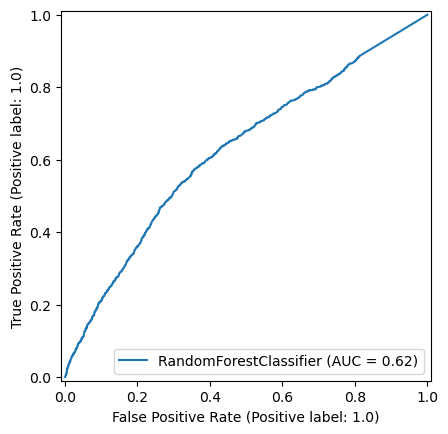

Accuracy of the binary classifier = 0.770 , ROC_AUC =  0.5645942724902222
Iteration 1, loss = 0.45089019
Validation score: 0.843509
Iteration 2, loss = 0.40519412
Validation score: 0.843509
Iteration 3, loss = 0.40090055
Validation score: 0.843509
Iteration 4, loss = 0.39743588
Validation score: 0.843509
Iteration 5, loss = 0.39496663
Validation score: 0.843509
Iteration 6, loss = 0.39339378
Validation score: 0.842545
Iteration 7, loss = 0.39070933
Validation score: 0.837725
Iteration 8, loss = 0.38846958
Validation score: 0.842545
Iteration 9, loss = 0.38604322
Validation score: 0.838368
Iteration 10, loss = 0.38570061
Validation score: 0.835797
Iteration 11, loss = 0.38245227
Validation score: 0.838046
Iteration 12, loss = 0.38062346
Validation score: 0.836118
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1217 forced predictions
[0.26629743 0.26629743 0.26629743 0.26625641 0.26605136 0.26602058
 0.26568664 0.26565456

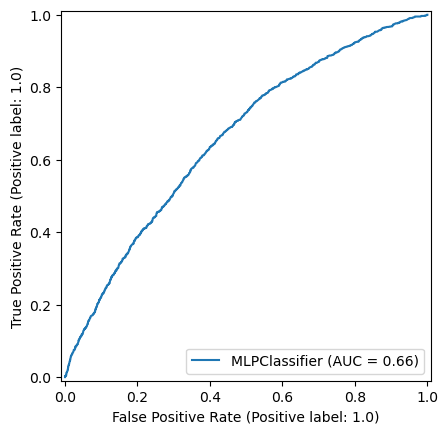

Accuracy of the binary classifier = 0.775 , ROC_AUC =  0.5743348927924542
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1217.0/ 7780 = 15.6 %
Number of Callbacks in Test Set for Old People (After Treatment)  717.0/ 5096 = 14.099999999999998 %
Number of Callbacks in Test Set for Young People (After Treatment) 500.0/ 2684 = 18.6 %

Train Set
Number of Callbacks in Train Set (After Treatment) 4868.0/ 31120 = 15.6 %
Number of Callbacks in Train Set for Old People (After Treatment) 2865.0/ 20414 = 14.000000000000002 %
Number of Callbacks in Train Set for Young People (After Treatment) 2003.0/ 10706 = 18.7 % 

Printing the list of 1217 forced predictions
[0.30572972 0.30533333 0.30504694 0.30504694 0.30504694 0.30504694
 0.30406209 0.30406209 0.30406209 0.30406209 0.30406209 0.3040

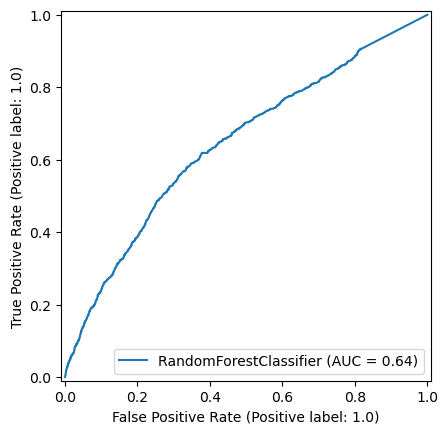

Accuracy of the binary classifier = 0.777 , ROC_AUC =  0.5767700478680122
Iteration 1, loss = 0.45232326
Validation score: 0.843509
Iteration 2, loss = 0.40781132
Validation score: 0.843509
Iteration 3, loss = 0.40394007
Validation score: 0.843509
Iteration 4, loss = 0.40164972
Validation score: 0.843509
Iteration 5, loss = 0.39919027
Validation score: 0.843509
Iteration 6, loss = 0.39782243
Validation score: 0.843509
Iteration 7, loss = 0.39643609
Validation score: 0.842545
Iteration 8, loss = 0.39320244
Validation score: 0.844152
Iteration 9, loss = 0.39097225
Validation score: 0.842224
Iteration 10, loss = 0.39175040
Validation score: 0.840617
Iteration 11, loss = 0.38728456
Validation score: 0.837082
Iteration 12, loss = 0.38562397
Validation score: 0.837404
Iteration 13, loss = 0.38343934
Validation score: 0.842224
Printing the list of 1217 forced predictions
[0.24062357 0.24062357 0.24050532 0.24050532 0.24050532 0.24050532
 0.24050532 0.24050532 0.24050532 0.24050532 0.24050532 

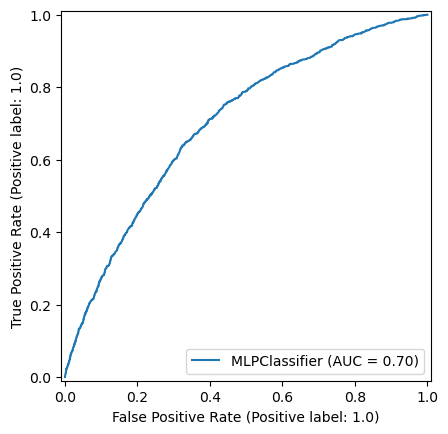

Accuracy of the binary classifier = 0.788 , ROC_AUC =  0.5981994125329231
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1217.0/ 7780 = 15.6 %
Number of Callbacks in Test Set for Old People (After Treatment)  700.0/ 5143 = 13.600000000000001 %
Number of Callbacks in Test Set for Young People (After Treatment) 517.0/ 2637 = 19.6 %

Train Set
Number of Callbacks in Train Set (After Treatment) 4868.0/ 31120 = 15.6 %
Number of Callbacks in Train Set for Old People (After Treatment) 2882.0/ 20367 = 14.2 %
Number of Callbacks in Train Set for Young People (After Treatment) 1986.0/ 10753 = 18.5 % 




KeyboardInterrupt



In [5]:
folds = 5
models_to_train = 5
stratify_Ar =  ["callback", "age_1.0", 'age_2.0', 'age_3.0', 'OBE', 'OBL', 'OH', 'OL', 'MB', 'MH', 'ML', 'Y']

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
    
analytics_base = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)

analytics_ebr = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)

equal_baserate_train_ITE_test = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)

analytics_ITE_test_flip = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)
#########
analytics_dict_base = {'base_rate': analytics_base,'equal_baserate': analytics_ebr, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test}

with open('./Data/base_analytics.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


## Accuracy vs. Fairness

Below we reproduce **Figure 2** from page 6, which illustrates the trade-off between **Accuracy** (AUC) and **Fairness** (FPRD).

- **AUC**
- **FPRD**: False Positive Rate Disparity:

  $$
  \text{FPRD} = \text{FPR}_{\text{young}} - \text{FPR}_{\text{old}}
  $$

- **FPRD > 0** indicates discrimination against older applicants.

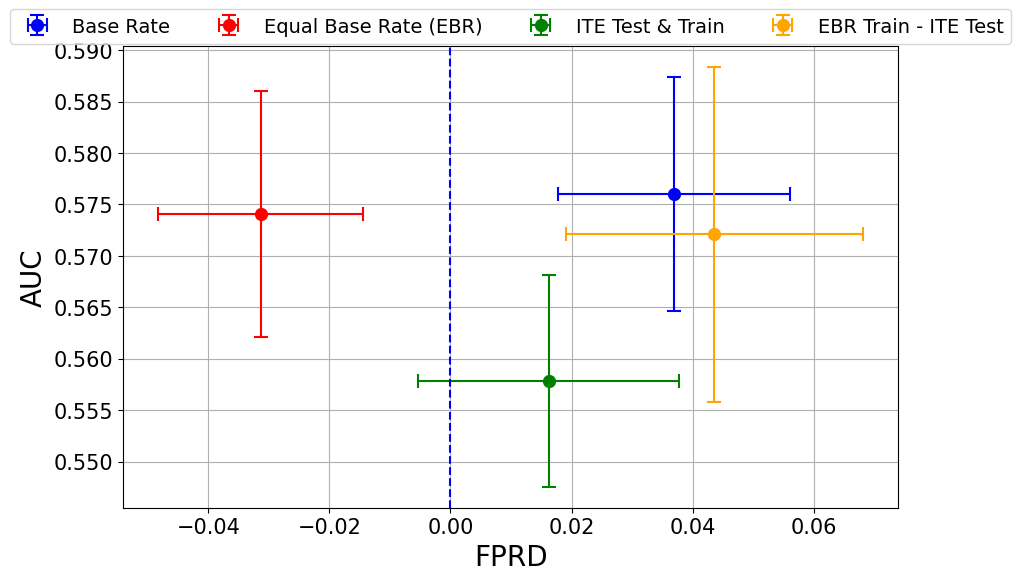

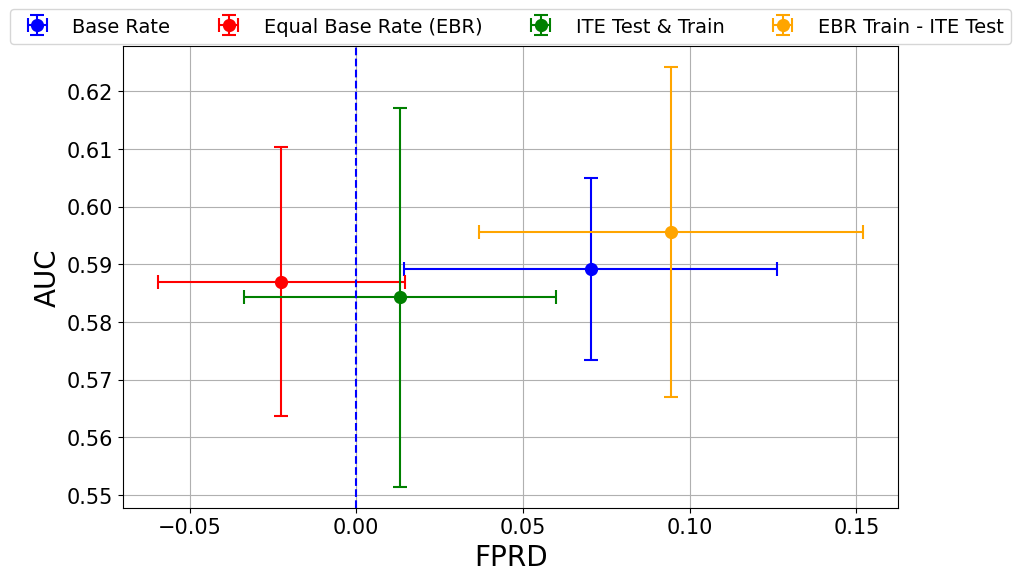

In [25]:
directory = './data/'
plot_mean_measurement_spot(directory, 'FP_dif', model="RFR")
plot_mean_measurement_spot(directory, 'FP_dif', model = 'MLP')

In [ ]:
perc_wpm_young, perc_wpm_old = 0.9, 0.1
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_09 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_09 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_09 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_09 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_09 = {'base_rate': analytics_base_09,'equal_baserate': analytics_ebr_09, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_09, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_09}

with open('./Data/base_analytics_09.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


In [ ]:
perc_wpm_young, perc_wpm_old = 0.9, 0.1
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_09 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_09 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_09 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_09 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_09 = {'base_rate': analytics_base_09,'equal_baserate': analytics_ebr_09, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_09, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_09}

with open('./Data/base_analytics_09.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


In [ ]:
perc_wpm_young, perc_wpm_old = 0.8, 0.2
#False means keep constant callbacks!!
perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_08 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_08 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_08 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_08 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_08 = {'base_rate': analytics_base_08,'equal_baserate': analytics_ebr_08, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_08, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_08}

with open('./Data/base_analytics_08.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


In [ ]:
perc_wpm_young, perc_wpm_old = 0.7, 0.3
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_07 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_07 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_07 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_07 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_07 = {'base_rate': analytics_base_07,'equal_baserate': analytics_ebr_07, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_07, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_07}

with open('./Data/base_analytics_07.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


Probability of spanish given Young: 59.996 %
Probability of spanish and receiving a Callback given Young: 24.403 %

Probability of spanish given Old: 39.997 %
Probability of spanish and receiving a Callback given Old: 23.776 %

Calculating probabilities for feature combinations of size 1
Calculating probabilities for feature combinations of size 2
Calculating probabilities for feature combinations of size 3
Probabilities saved to ./data/inject_bias_spanish_old_False_0_4_young_False_0_6_callback_probabilities.txt
Test Set
Number of Callbacks in Test Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (Before Treatment)  4582.0/ 25510 = 18.0 %
Number of Callbacks in Test Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 %

Train Set
Number of Callbacks in Train Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (Before Treatment) 4582.0/ 25510 = 18.0 %
Number of Call

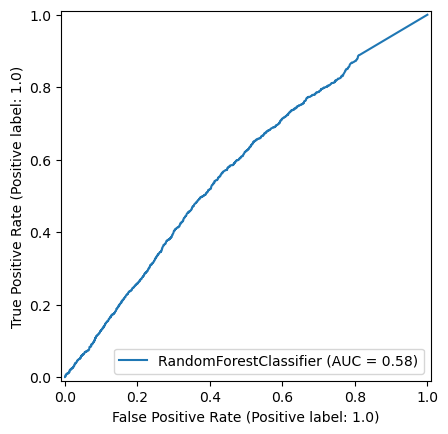

Accuracy of the binary classifier = 0.705 , ROC_AUC =  0.5283205002270879
Iteration 1, loss = 0.50979074
Validation score: 0.805913
Iteration 2, loss = 0.47587905
Validation score: 0.805913
Iteration 3, loss = 0.47134900
Validation score: 0.805913
Iteration 4, loss = 0.46863581
Validation score: 0.805913
Iteration 5, loss = 0.46600552
Validation score: 0.806234
Iteration 6, loss = 0.46376066
Validation score: 0.806555
Iteration 7, loss = 0.46181693
Validation score: 0.806877
Iteration 8, loss = 0.45999851
Validation score: 0.806555
Iteration 9, loss = 0.45725773
Validation score: 0.805913
Iteration 10, loss = 0.45601909
Validation score: 0.804949
Iteration 11, loss = 0.45413499
Validation score: 0.803663
Iteration 12, loss = 0.45133486
Validation score: 0.801093
Iteration 13, loss = 0.44949102
Validation score: 0.800129
Iteration 14, loss = 0.44592314
Validation score: 0.804306
Iteration 15, loss = 0.44450595
Validation score: 0.802378
Iteration 16, loss = 0.44144084
Validation score: 

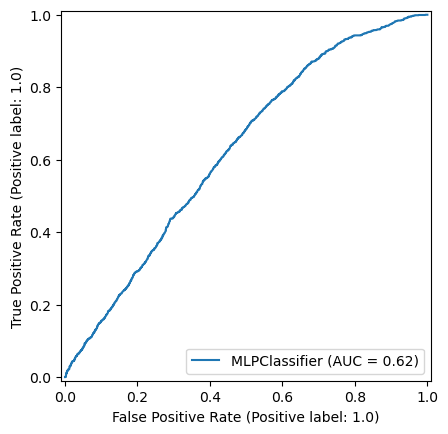

Accuracy of the binary classifier = 0.712 , ROC_AUC =  0.5402357489147311
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  915.0/ 5070 = 18.0 %
Number of Callbacks in Test Set for Young People (After Treatment) 595.0/ 2710 = 22.0 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6037.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3667.0/ 20440 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2370.0/ 10680 = 22.2 % 

Printing the list of 1510 forced predictions
[0.33761111 0.3375     0.33749567 0.33749567 0.33749567 0.3372585
 0.3372585  0.33723016 0.33723016 0.33723016 0.33714286 0.33714

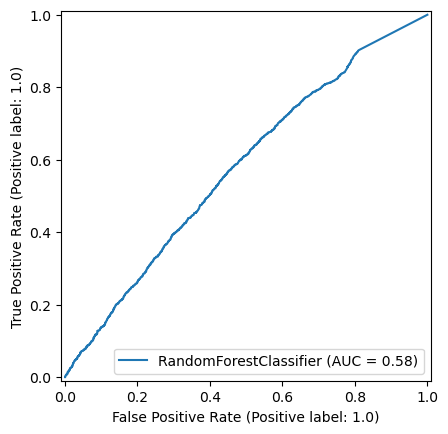

Accuracy of the binary classifier = 0.707 , ROC_AUC =  0.5311965947378983
Iteration 1, loss = 0.50984877
Validation score: 0.805913
Iteration 2, loss = 0.47613639
Validation score: 0.805913
Iteration 3, loss = 0.47141470
Validation score: 0.805913
Iteration 4, loss = 0.46849464
Validation score: 0.805913
Iteration 5, loss = 0.46613650
Validation score: 0.805913
Iteration 6, loss = 0.46319567
Validation score: 0.805913
Iteration 7, loss = 0.46181641
Validation score: 0.806234
Iteration 8, loss = 0.45927730
Validation score: 0.805591
Iteration 9, loss = 0.45757087
Validation score: 0.805270
Iteration 10, loss = 0.45625819
Validation score: 0.804306
Iteration 11, loss = 0.45356967
Validation score: 0.803985
Iteration 12, loss = 0.45249703
Validation score: 0.804627
Iteration 13, loss = 0.44988110
Validation score: 0.804306
Iteration 14, loss = 0.44636353
Validation score: 0.804627
Iteration 15, loss = 0.44420986
Validation score: 0.802057
Iteration 16, loss = 0.44192594
Validation score: 

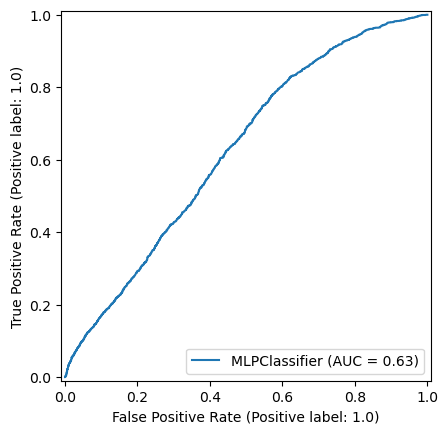

Accuracy of the binary classifier = 0.714 , ROC_AUC =  0.54270097278114
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  921.0/ 5081 = 18.099999999999998 %
Number of Callbacks in Test Set for Young People (After Treatment) 588.0/ 2699 = 21.8 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3661.0/ 20429 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2377.0/ 10691 = 22.2 % 

Printing the list of 1509 forced predictions
[0.3422381  0.3422381  0.34166667 0.34136508 0.34136508 0.34124098
 0.34124098 0.34124098 0.34112698 0.34069979 0.340

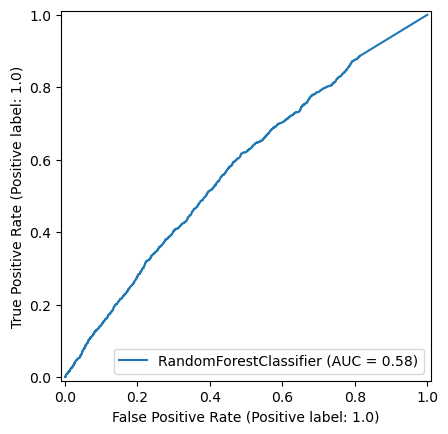

Accuracy of the binary classifier = 0.708 , ROC_AUC =  0.5338382715982846
Iteration 1, loss = 0.50919726
Validation score: 0.805913
Iteration 2, loss = 0.47500427
Validation score: 0.805913
Iteration 3, loss = 0.47026088
Validation score: 0.805913
Iteration 4, loss = 0.46779434
Validation score: 0.805913
Iteration 5, loss = 0.46536909
Validation score: 0.805913
Iteration 6, loss = 0.46311857
Validation score: 0.805913
Iteration 7, loss = 0.46018089
Validation score: 0.805913
Iteration 8, loss = 0.45868869
Validation score: 0.804949
Iteration 9, loss = 0.45616929
Validation score: 0.805270
Iteration 10, loss = 0.45394128
Validation score: 0.803663
Iteration 11, loss = 0.45152600
Validation score: 0.801735
Iteration 12, loss = 0.45014603
Validation score: 0.804627
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.26352672 0.26341227 0.26341227 0.26341227 0.26341227 0.26341227
 0.26341227 0.26341227

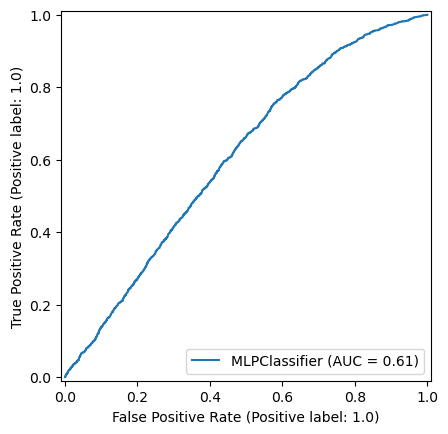

Accuracy of the binary classifier = 0.708 , ROC_AUC =  0.5326050395125658
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  930.0/ 5190 = 17.9 %
Number of Callbacks in Test Set for Young People (After Treatment) 579.0/ 2590 = 22.400000000000002 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3652.0/ 20320 = 18.0 %
Number of Callbacks in Train Set for Young People (After Treatment) 2386.0/ 10800 = 22.1 % 

Printing the list of 1509 forced predictions
[0.33553771 0.33553771 0.33553771 0.3352013  0.33513531 0.33513531
 0.33513531 0.33513531 0.33513531 0.33513531 0.3

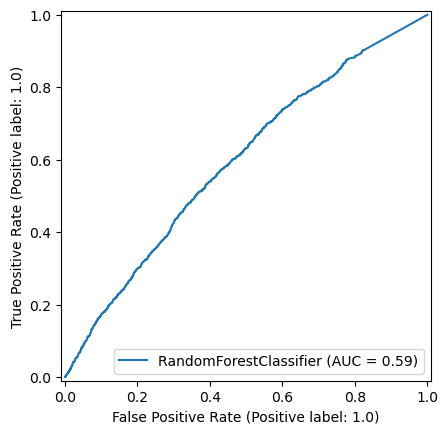

Accuracy of the binary classifier = 0.715 , ROC_AUC =  0.5437041282840351
Iteration 1, loss = 0.51010245
Validation score: 0.805913
Iteration 2, loss = 0.47637203
Validation score: 0.805913
Iteration 3, loss = 0.47181579
Validation score: 0.805913
Iteration 4, loss = 0.46933276
Validation score: 0.805913
Iteration 5, loss = 0.46671319
Validation score: 0.805913
Iteration 6, loss = 0.46482186
Validation score: 0.805913
Iteration 7, loss = 0.46397699
Validation score: 0.806234
Iteration 8, loss = 0.46089858
Validation score: 0.805913
Iteration 9, loss = 0.45910803
Validation score: 0.806555
Iteration 10, loss = 0.45647181
Validation score: 0.805913
Iteration 11, loss = 0.45438874
Validation score: 0.806555
Iteration 12, loss = 0.45241128
Validation score: 0.806555
Iteration 13, loss = 0.45159573
Validation score: 0.805913
Iteration 14, loss = 0.44790941
Validation score: 0.805591
Iteration 15, loss = 0.44541473
Validation score: 0.804949
Iteration 16, loss = 0.44445516
Validation score: 

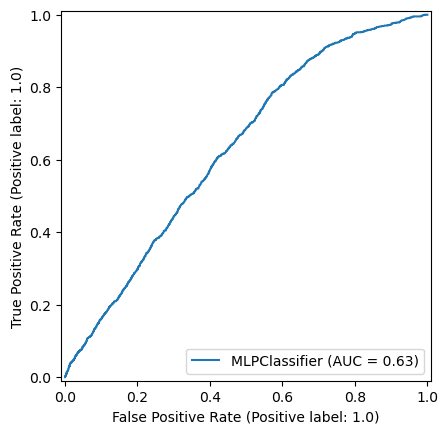

Accuracy of the binary classifier = 0.715 , ROC_AUC =  0.5437041282840351
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  922.0/ 5096 = 18.099999999999998 %
Number of Callbacks in Test Set for Young People (After Treatment) 587.0/ 2684 = 21.9 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3660.0/ 20414 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2378.0/ 10706 = 22.2 % 

Printing the list of 1509 forced predictions
[0.3365653  0.3365653  0.3365653  0.33655924 0.33655924 0.33655924
 0.33639733 0.33639733 0.33639733 0.33639733 0.3

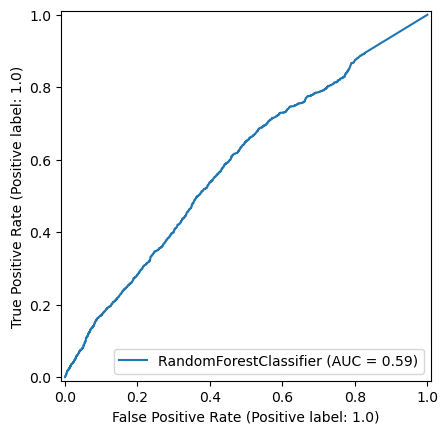

Accuracy of the binary classifier = 0.712 , ROC_AUC =  0.5395933546649725
Iteration 1, loss = 0.51023531
Validation score: 0.805913
Iteration 2, loss = 0.47717492
Validation score: 0.805913
Iteration 3, loss = 0.47268684
Validation score: 0.805913
Iteration 4, loss = 0.47001019
Validation score: 0.805913
Iteration 5, loss = 0.46794001
Validation score: 0.805913
Iteration 6, loss = 0.46585640
Validation score: 0.805913
Iteration 7, loss = 0.46366957
Validation score: 0.805591
Iteration 8, loss = 0.46230317
Validation score: 0.804627
Iteration 9, loss = 0.46018170
Validation score: 0.804306
Iteration 10, loss = 0.45846704
Validation score: 0.803663
Iteration 11, loss = 0.45650148
Validation score: 0.804306
Iteration 12, loss = 0.45413162
Validation score: 0.803021
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.24575819 0.24575819 0.24575819 0.24571433 0.24571433 0.24571433
 0.24571433 0.24571433

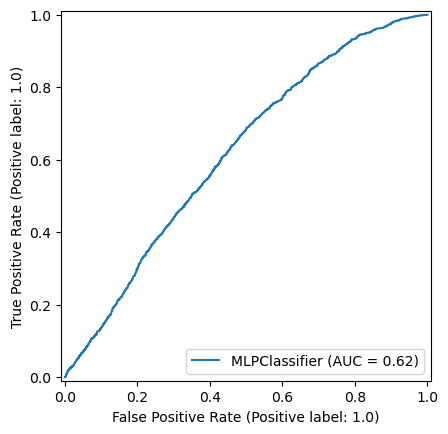

Accuracy of the binary classifier = 0.713 , ROC_AUC =  0.540415509388785
Test Set
Number of Callbacks in Test Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (Before Treatment)  4582.0/ 25510 = 18.0 %
Number of Callbacks in Test Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 %

Train Set
Number of Callbacks in Train Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (Before Treatment) 4582.0/ 25510 = 18.0 %
Number of Callbacks in Train Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 % 

['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  911

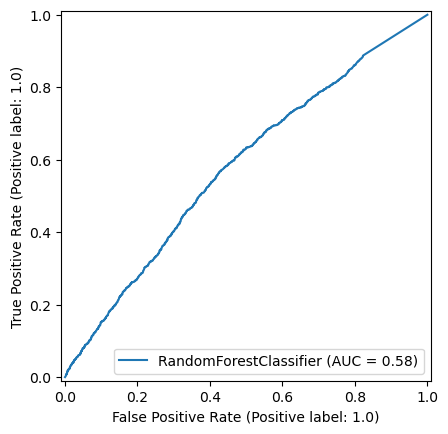

Accuracy of the binary classifier = 0.711 , ROC_AUC =  0.5373596544039208
Iteration 1, loss = 0.51046203
Validation score: 0.805913
Iteration 2, loss = 0.47651929
Validation score: 0.805913
Iteration 3, loss = 0.47258294
Validation score: 0.805913
Iteration 4, loss = 0.46947784
Validation score: 0.805913
Iteration 5, loss = 0.46725310
Validation score: 0.805913
Iteration 6, loss = 0.46525976
Validation score: 0.806234
Iteration 7, loss = 0.46275512
Validation score: 0.806234
Iteration 8, loss = 0.46212836
Validation score: 0.806234
Iteration 9, loss = 0.45903579
Validation score: 0.806555
Iteration 10, loss = 0.45745099
Validation score: 0.806234
Iteration 11, loss = 0.45589259
Validation score: 0.806555
Iteration 12, loss = 0.45331663
Validation score: 0.806555
Iteration 13, loss = 0.45103101
Validation score: 0.805913
Iteration 14, loss = 0.44878042
Validation score: 0.803663
Iteration 15, loss = 0.44663487
Validation score: 0.803985
Iteration 16, loss = 0.44503923
Validation score: 

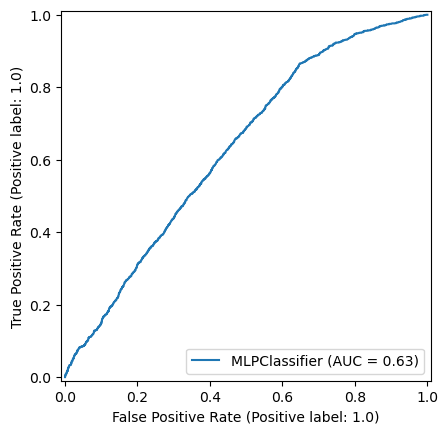

Accuracy of the binary classifier = 0.717 , ROC_AUC =  0.548453161802761
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  916.0/ 5153 = 17.8 %
Number of Callbacks in Test Set for Young People (After Treatment) 594.0/ 2627 = 22.6 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6037.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3666.0/ 20357 = 18.0 %
Number of Callbacks in Train Set for Young People (After Treatment) 2371.0/ 10763 = 22.0 % 

Printing the list of 1510 forced predictions
[0.33680258 0.3365671  0.3365671  0.3365671  0.3365671  0.33648714
 0.33648714 0.33644883 0.33644883 0.33644883 0.33644883 0.33644

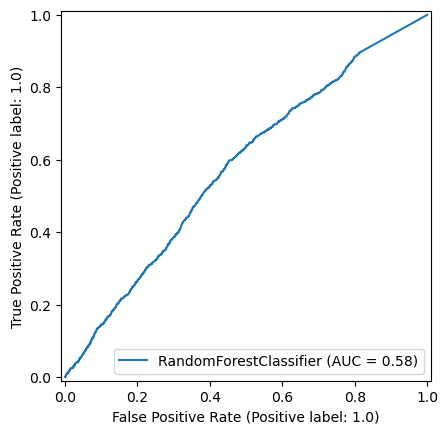

Accuracy of the binary classifier = 0.706 , ROC_AUC =  0.5303748534490954
Iteration 1, loss = 0.51025302
Validation score: 0.805913
Iteration 2, loss = 0.47574623
Validation score: 0.805913
Iteration 3, loss = 0.47137038
Validation score: 0.805913
Iteration 4, loss = 0.46852655
Validation score: 0.805913
Iteration 5, loss = 0.46613598
Validation score: 0.805913
Iteration 6, loss = 0.46419784
Validation score: 0.805913
Iteration 7, loss = 0.46231633
Validation score: 0.805591
Iteration 8, loss = 0.46118994
Validation score: 0.805591
Iteration 9, loss = 0.45800050
Validation score: 0.804627
Iteration 10, loss = 0.45612430
Validation score: 0.804627
Iteration 11, loss = 0.45426182
Validation score: 0.804949
Iteration 12, loss = 0.45210852
Validation score: 0.805270
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1510 forced predictions
[0.24515643 0.24508716 0.24508716 0.24507326 0.24499273 0.24499273
 0.24499273 0.24491666

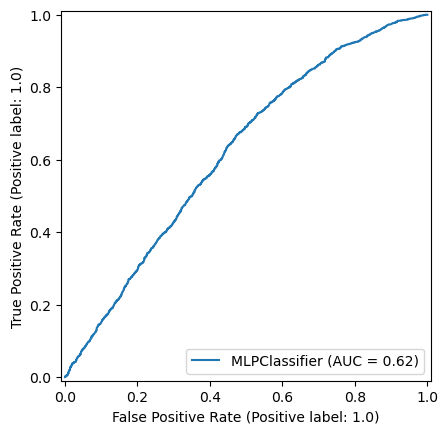

Accuracy of the binary classifier = 0.716 , ROC_AUC =  0.546809679225155
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  905.0/ 5085 = 17.8 %
Number of Callbacks in Test Set for Young People (After Treatment) 604.0/ 2695 = 22.400000000000002 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3677.0/ 20425 = 18.0 %
Number of Callbacks in Train Set for Young People (After Treatment) 2361.0/ 10695 = 22.1 % 

Printing the list of 1509 forced predictions
[0.33626271 0.33626271 0.33626271 0.336      0.33598091 0.33591019
 0.33588889 0.33588889 0.33588889 0.33588095 0.33

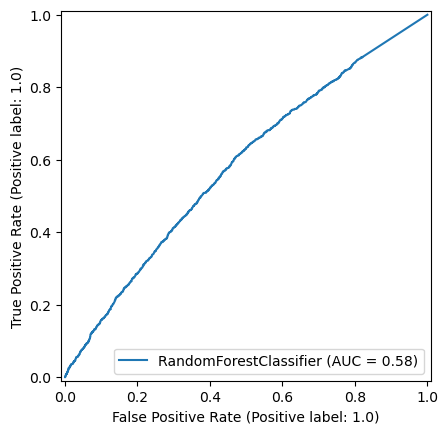

Accuracy of the binary classifier = 0.713 , ROC_AUC =  0.5408265867506913
Iteration 1, loss = 0.50983353
Validation score: 0.805913
Iteration 2, loss = 0.47683896
Validation score: 0.805913
Iteration 3, loss = 0.47245391
Validation score: 0.805913
Iteration 4, loss = 0.46938334
Validation score: 0.805913
Iteration 5, loss = 0.46737721
Validation score: 0.805913
Iteration 6, loss = 0.46476507
Validation score: 0.805591
Iteration 7, loss = 0.46361674
Validation score: 0.805591
Iteration 8, loss = 0.46121014
Validation score: 0.805591
Iteration 9, loss = 0.45827140
Validation score: 0.805270
Iteration 10, loss = 0.45663286
Validation score: 0.805913
Iteration 11, loss = 0.45484141
Validation score: 0.804306
Iteration 12, loss = 0.45284784
Validation score: 0.804949
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.25151808 0.25151808 0.25151808 0.25151808 0.25151808 0.2514121
 0.2514121  0.2514121  

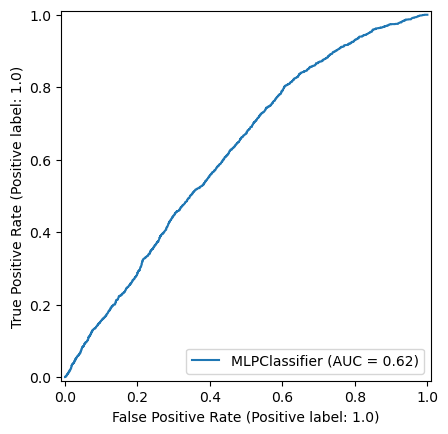

Accuracy of the binary classifier = 0.711 , ROC_AUC =  0.5383601225792537
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  945.0/ 5151 = 18.3 %
Number of Callbacks in Test Set for Young People (After Treatment) 564.0/ 2629 = 21.5 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3637.0/ 20359 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2401.0/ 10761 = 22.3 % 

Printing the list of 1509 forced predictions
[0.33952217 0.33952217 0.33926407 0.33926407 0.33926407 0.33914574
 0.33910317 0.33904762 0.33904762 0.33904762 0.33904762 0.3387

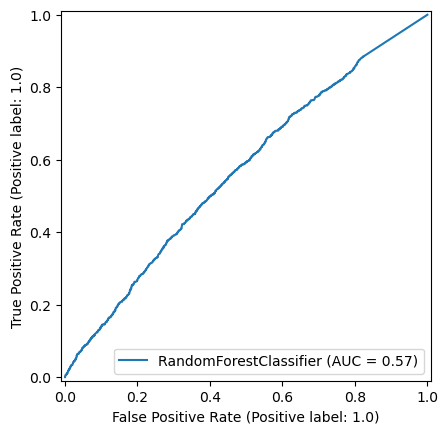

Accuracy of the binary classifier = 0.707 , ROC_AUC =  0.5309607300649407
Iteration 1, loss = 0.50920641
Validation score: 0.805913
Iteration 2, loss = 0.47552573
Validation score: 0.805913
Iteration 3, loss = 0.47171776
Validation score: 0.805913
Iteration 4, loss = 0.46862224
Validation score: 0.805913
Iteration 5, loss = 0.46541570
Validation score: 0.805913
Iteration 6, loss = 0.46343341
Validation score: 0.805913
Iteration 7, loss = 0.46113296
Validation score: 0.805913
Iteration 8, loss = 0.46027814
Validation score: 0.805591
Iteration 9, loss = 0.45709084
Validation score: 0.805913
Iteration 10, loss = 0.45476822
Validation score: 0.804306
Iteration 11, loss = 0.45298186
Validation score: 0.803342
Iteration 12, loss = 0.45119854
Validation score: 0.805591
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.2586342  0.2586342  0.25861371 0.25860495 0.25860495 0.25847669
 0.25843067 0.25843067

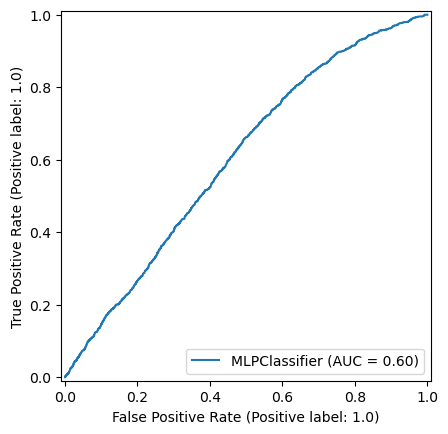

Accuracy of the binary classifier = 0.705 , ROC_AUC =  0.5289053432554094
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  905.0/ 5048 = 17.9 %
Number of Callbacks in Test Set for Young People (After Treatment) 604.0/ 2732 = 22.1 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3677.0/ 20462 = 18.0 %
Number of Callbacks in Train Set for Young People (After Treatment) 2361.0/ 10658 = 22.2 % 

Printing the list of 1509 forced predictions
[0.34006349 0.34       0.33971429 0.33971429 0.33969841 0.33969841
 0.33969841 0.33969841 0.33951671 0.33951671 0.33942498 0.3392

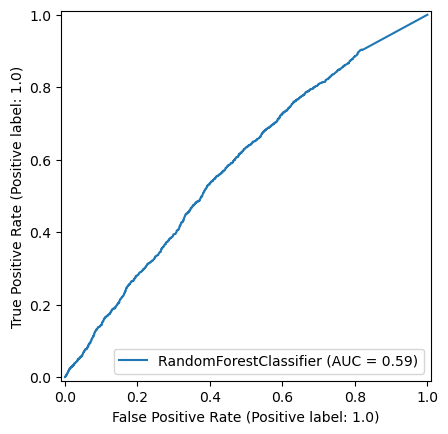

Accuracy of the binary classifier = 0.712 , ROC_AUC =  0.5391822773030662
Iteration 1, loss = 0.50979700
Validation score: 0.805913
Iteration 2, loss = 0.47561949
Validation score: 0.805913
Iteration 3, loss = 0.47140753
Validation score: 0.805913
Iteration 4, loss = 0.46885731
Validation score: 0.805913
Iteration 5, loss = 0.46631069
Validation score: 0.805913
Iteration 6, loss = 0.46401020
Validation score: 0.805913
Iteration 7, loss = 0.46249792
Validation score: 0.805913
Iteration 8, loss = 0.46077844
Validation score: 0.805913
Iteration 9, loss = 0.45846391
Validation score: 0.805913
Iteration 10, loss = 0.45802478
Validation score: 0.805591
Iteration 11, loss = 0.45429342
Validation score: 0.804306
Iteration 12, loss = 0.45297270
Validation score: 0.804306
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.25678734 0.2567799  0.25674161 0.25674161 0.25673996 0.25673996
 0.25673996 0.25673996

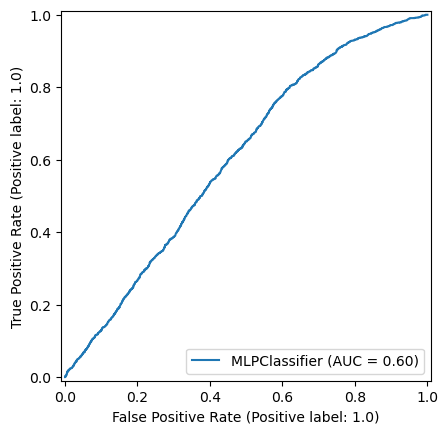

Accuracy of the binary classifier = 0.706 , ROC_AUC =  0.5297274979792219
Test Set
Number of Callbacks in Test Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (Before Treatment)  4582.0/ 25510 = 18.0 %
Number of Callbacks in Test Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 %

Train Set
Number of Callbacks in Train Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (Before Treatment) 4582.0/ 25510 = 18.0 %
Number of Callbacks in Train Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 % 

['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  87

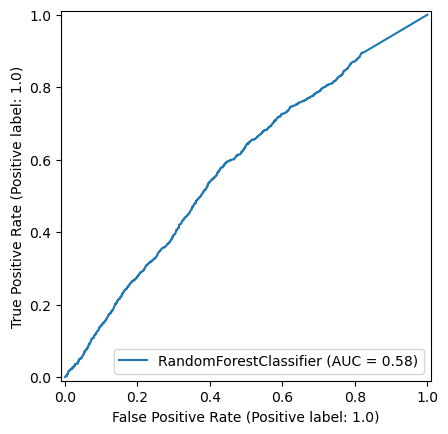

Accuracy of the binary classifier = 0.712 , ROC_AUC =  0.5390031369815267
Iteration 1, loss = 0.50954923
Validation score: 0.805913
Iteration 2, loss = 0.47509717
Validation score: 0.805913
Iteration 3, loss = 0.47113579
Validation score: 0.805913
Iteration 4, loss = 0.46843344
Validation score: 0.805913
Iteration 5, loss = 0.46538467
Validation score: 0.805913
Iteration 6, loss = 0.46294420
Validation score: 0.806555
Iteration 7, loss = 0.46093015
Validation score: 0.806877
Iteration 8, loss = 0.45894495
Validation score: 0.806877
Iteration 9, loss = 0.45661275
Validation score: 0.806877
Iteration 10, loss = 0.45427454
Validation score: 0.803985
Iteration 11, loss = 0.45311820
Validation score: 0.803021
Iteration 12, loss = 0.45075869
Validation score: 0.804306
Iteration 13, loss = 0.44779193
Validation score: 0.802378
Iteration 14, loss = 0.44523374
Validation score: 0.802057
Iteration 15, loss = 0.44265017
Validation score: 0.798201
Iteration 16, loss = 0.44124681
Validation score: 

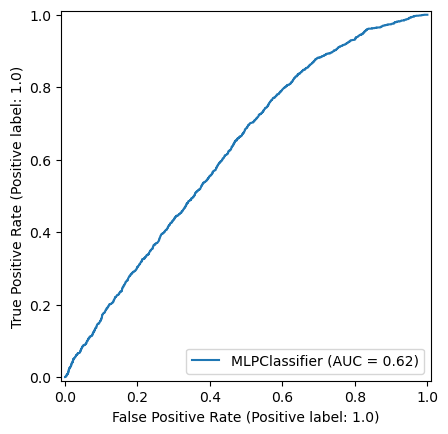

Accuracy of the binary classifier = 0.718 , ROC_AUC =  0.5492749030915639
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  923.0/ 5083 = 18.2 %
Number of Callbacks in Test Set for Young People (After Treatment) 587.0/ 2697 = 21.8 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6037.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3659.0/ 20427 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2378.0/ 10693 = 22.2 % 

Printing the list of 1510 forced predictions
[0.34404762 0.344      0.34366667 0.34327056 0.34327056 0.34327056
 0.34327056 0.34327056 0.3432381  0.3432381  0.3432381  0.3428

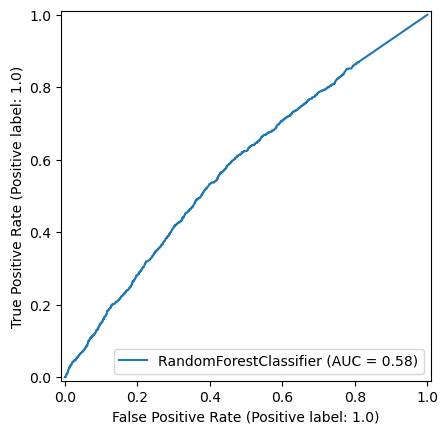

Accuracy of the binary classifier = 0.708 , ROC_AUC =  0.5340726892487089
Iteration 1, loss = 0.50989653
Validation score: 0.805913
Iteration 2, loss = 0.47597328
Validation score: 0.805913
Iteration 3, loss = 0.47138324
Validation score: 0.805913
Iteration 4, loss = 0.46829170
Validation score: 0.805913
Iteration 5, loss = 0.46612633
Validation score: 0.805913
Iteration 6, loss = 0.46379386
Validation score: 0.805913
Iteration 7, loss = 0.46170961
Validation score: 0.805591
Iteration 8, loss = 0.46012399
Validation score: 0.804949
Iteration 9, loss = 0.45724448
Validation score: 0.804627
Iteration 10, loss = 0.45516505
Validation score: 0.802378
Iteration 11, loss = 0.45402244
Validation score: 0.802057
Iteration 12, loss = 0.45060688
Validation score: 0.802057
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1510 forced predictions
[0.25664068 0.25664068 0.25663562 0.25663562 0.25663562 0.25663562
 0.25663562 0.25663562

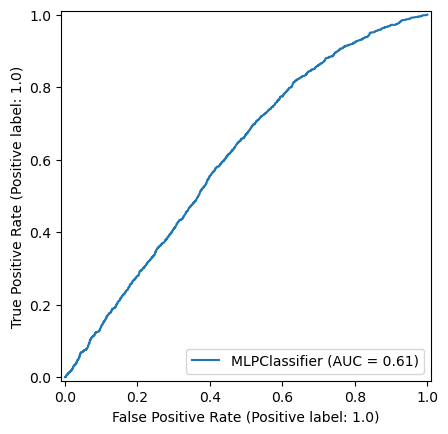

Accuracy of the binary classifier = 0.711 , ROC_AUC =  0.5385922663371252
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  939.0/ 5126 = 18.3 %
Number of Callbacks in Test Set for Young People (After Treatment) 570.0/ 2654 = 21.5 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3643.0/ 20384 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2395.0/ 10736 = 22.3 % 

Printing the list of 1509 forced predictions
[0.34817924 0.34738095 0.34738095 0.34721429 0.34669048 0.34669048
 0.34669048 0.34665152 0.34663203 0.34663203 0.34660497 0.3466

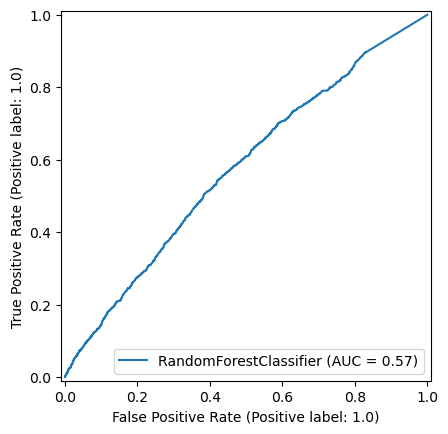

Accuracy of the binary classifier = 0.709 , ROC_AUC =  0.5350715036840034
Iteration 1, loss = 0.51048508
Validation score: 0.805913
Iteration 2, loss = 0.47623884
Validation score: 0.805913
Iteration 3, loss = 0.47174402
Validation score: 0.805913
Iteration 4, loss = 0.46913717
Validation score: 0.805913
Iteration 5, loss = 0.46651798
Validation score: 0.805913
Iteration 6, loss = 0.46410828
Validation score: 0.806234
Iteration 7, loss = 0.46164344
Validation score: 0.805913
Iteration 8, loss = 0.45976297
Validation score: 0.806234
Iteration 9, loss = 0.45693918
Validation score: 0.806234
Iteration 10, loss = 0.45575209
Validation score: 0.804949
Iteration 11, loss = 0.45346667
Validation score: 0.803663
Iteration 12, loss = 0.45074851
Validation score: 0.805591
Iteration 13, loss = 0.44954831
Validation score: 0.804627
Iteration 14, loss = 0.44630464
Validation score: 0.804306
Iteration 15, loss = 0.44372652
Validation score: 0.805591
Iteration 16, loss = 0.44204888
Validation score: 

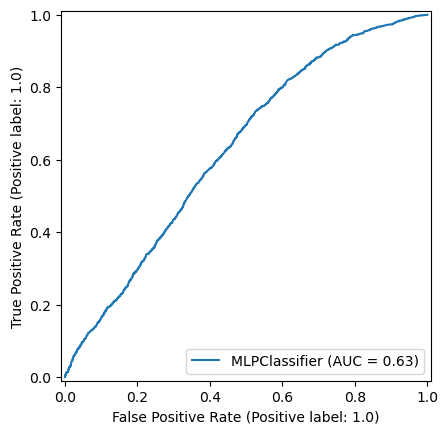

Accuracy of the binary classifier = 0.714 , ROC_AUC =  0.543293050922129
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  934.0/ 5103 = 18.3 %
Number of Callbacks in Test Set for Young People (After Treatment) 575.0/ 2677 = 21.5 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3648.0/ 20407 = 17.9 %
Number of Callbacks in Train Set for Young People (After Treatment) 2390.0/ 10713 = 22.3 % 

Printing the list of 1509 forced predictions
[0.33414286 0.33414286 0.33414286 0.33397908 0.33397908 0.33397908
 0.33396032 0.33366667 0.33349278 0.33317788 0.33311111 0.33311

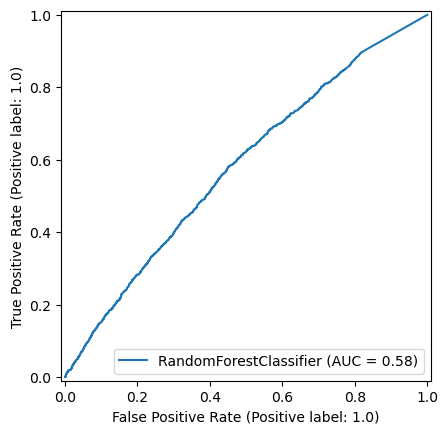

Accuracy of the binary classifier = 0.712 , ROC_AUC =  0.5395933546649725
Iteration 1, loss = 0.50928115
Validation score: 0.805913
Iteration 2, loss = 0.47532013
Validation score: 0.805913
Iteration 3, loss = 0.47114953
Validation score: 0.805913
Iteration 4, loss = 0.46857387
Validation score: 0.805913
Iteration 5, loss = 0.46586924
Validation score: 0.805913
Iteration 6, loss = 0.46402582
Validation score: 0.805913
Iteration 7, loss = 0.46196416
Validation score: 0.805913
Iteration 8, loss = 0.45976945
Validation score: 0.806234
Iteration 9, loss = 0.45814156
Validation score: 0.806234
Iteration 10, loss = 0.45522344
Validation score: 0.806234
Iteration 11, loss = 0.45380067
Validation score: 0.805270
Iteration 12, loss = 0.45114872
Validation score: 0.805591
Iteration 13, loss = 0.44917762
Validation score: 0.803342
Iteration 14, loss = 0.44677268
Validation score: 0.805913
Iteration 15, loss = 0.44363906
Validation score: 0.804627
Iteration 16, loss = 0.44267720
Validation score: 

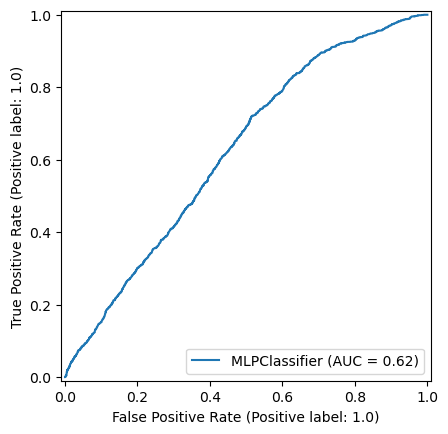

Accuracy of the binary classifier = 0.716 , ROC_AUC =  0.5465816698173792
['fold_1_test', 'fold_2_test', 'fold_3_test', 'fold_4_test', 'fold_5_test']
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  915.0/ 5161 = 17.7 %
Number of Callbacks in Test Set for Young People (After Treatment) 594.0/ 2619 = 22.7 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 31120 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (After Treatment) 3667.0/ 20349 = 18.0 %
Number of Callbacks in Train Set for Young People (After Treatment) 2371.0/ 10771 = 22.0 % 

Printing the list of 1509 forced predictions
[0.32466221 0.32466221 0.32463853 0.32416289 0.32416289 0.32416289
 0.3237619  0.32376046 0.32361266 0.32361266 0.32361266 0.3236

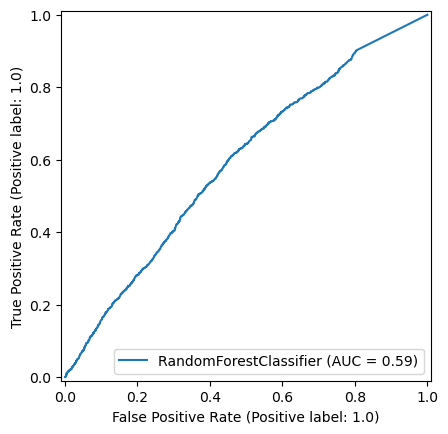

Accuracy of the binary classifier = 0.711 , ROC_AUC =  0.5379490452173474
Iteration 1, loss = 0.51042029
Validation score: 0.805913
Iteration 2, loss = 0.47636861
Validation score: 0.805913
Iteration 3, loss = 0.47194292
Validation score: 0.805913
Iteration 4, loss = 0.46919715
Validation score: 0.805913
Iteration 5, loss = 0.46725215
Validation score: 0.805913
Iteration 6, loss = 0.46436635
Validation score: 0.805591
Iteration 7, loss = 0.46301960
Validation score: 0.805591
Iteration 8, loss = 0.46057250
Validation score: 0.805270
Iteration 9, loss = 0.45813574
Validation score: 0.805270
Iteration 10, loss = 0.45584298
Validation score: 0.805270
Iteration 11, loss = 0.45370424
Validation score: 0.804627
Iteration 12, loss = 0.45143303
Validation score: 0.803342
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Printing the list of 1509 forced predictions
[0.24521157 0.24518362 0.24518362 0.24518362 0.24518362 0.24518362
 0.24518362 0.24518362

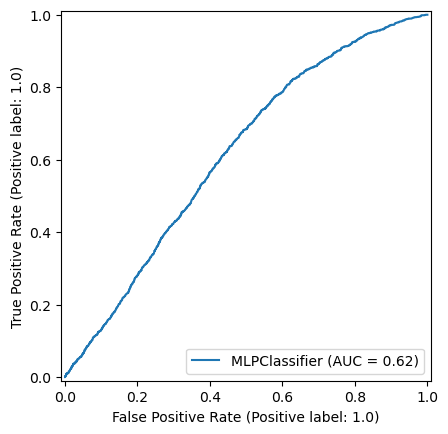

Accuracy of the binary classifier = 0.708 , ROC_AUC =  0.5338382715982846
Test Set
Number of Callbacks in Test Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (Before Treatment)  4582.0/ 25510 = 18.0 %
Number of Callbacks in Test Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 %

Train Set
Number of Callbacks in Train Set (Before Treatment) 7547.0/ 38900 = 19.400000000000002 %
Number of Callbacks in Train Set for Old People (Before Treatment) 4582.0/ 25510 = 18.0 %
Number of Callbacks in Train Set for Young People (Before Treatment) 2965.0/ 13390 = 22.1 % 

Equalized Base Rate difference, closest final difference = 8.349788139816461e-05
[]
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatm

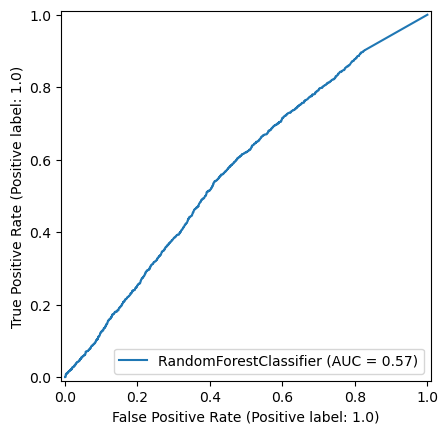

Accuracy of the binary classifier = 0.702 , ROC_AUC =  0.524211793783073
Iteration 1, loss = 0.54571795
Validation score: 0.780124
Iteration 2, loss = 0.51156021
Validation score: 0.780124
Iteration 3, loss = 0.50603982
Validation score: 0.780124
Iteration 4, loss = 0.50306123
Validation score: 0.780124
Iteration 5, loss = 0.50027382
Validation score: 0.780124
Iteration 6, loss = 0.49772434
Validation score: 0.779760
Iteration 7, loss = 0.49591567
Validation score: 0.780852
Iteration 8, loss = 0.49280242
Validation score: 0.777940
Iteration 9, loss = 0.48976674
Validation score: 0.780488
Iteration 10, loss = 0.48747641
Validation score: 0.776483
Iteration 11, loss = 0.48428124
Validation score: 0.778304
Iteration 12, loss = 0.48150599
Validation score: 0.775755
Iteration 13, loss = 0.47954114
Validation score: 0.774663
Iteration 14, loss = 0.47672347
Validation score: 0.776847
Iteration 15, loss = 0.47323394
Validation score: 0.774299
Iteration 16, loss = 0.47191449
Validation score: 0

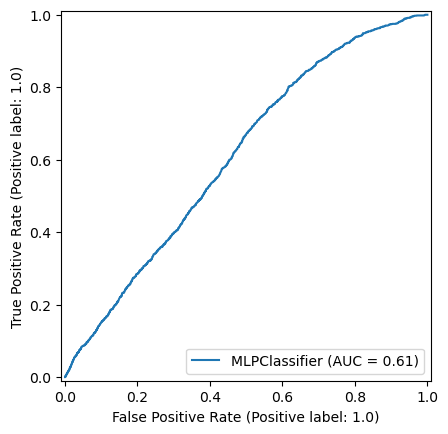

Accuracy of the binary classifier = 0.711 , ROC_AUC =  0.5385922663371252
Equalized Base Rate difference, closest final difference = 8.445147999092129e-05
[]
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1510.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  915.0/ 5070 = 18.0 %
Number of Callbacks in Test Set for Young People (After Treatment) 595.0/ 2710 = 22.0 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6037.0/ 27211 = 22.2 %
Number of Callbacks in Train Set for Old People (After Treatment) 3667.0/ 16531 = 22.2 %
Number of Callbacks in Train Set for Young People (After Treatment) 2370.0/ 10680 = 22.2 % 

Printing the list of 1510 forced predictions
[0.37335775 0.37314286 0.37304469 0.37290476 0.37224513 0.37224513
 0.37224513 0.37224513 0.37224513 0.37224513 0.37224513 0.37224301
 

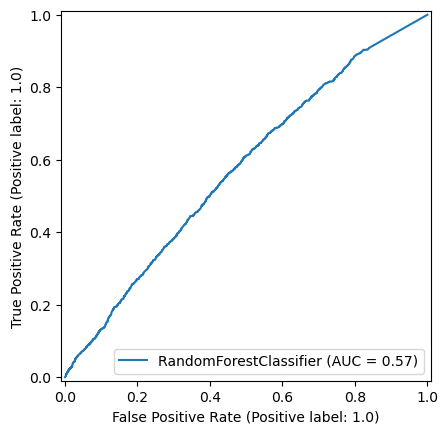

Accuracy of the binary classifier = 0.708 , ROC_AUC =  0.5328400773155043
Iteration 1, loss = 0.54571989
Validation score: 0.778104
Iteration 2, loss = 0.51413617
Validation score: 0.778104
Iteration 3, loss = 0.50882997
Validation score: 0.778104
Iteration 4, loss = 0.50497235
Validation score: 0.778104
Iteration 5, loss = 0.50269166
Validation score: 0.778472
Iteration 6, loss = 0.49923225
Validation score: 0.778472
Iteration 7, loss = 0.49713590
Validation score: 0.778472
Iteration 8, loss = 0.49393298
Validation score: 0.778472
Iteration 9, loss = 0.49112541
Validation score: 0.775533
Iteration 10, loss = 0.48825926
Validation score: 0.775533
Iteration 11, loss = 0.48538590
Validation score: 0.776267
Iteration 12, loss = 0.48287009
Validation score: 0.778104
Iteration 13, loss = 0.48029217
Validation score: 0.777370
Iteration 14, loss = 0.47908182
Validation score: 0.773328
Iteration 15, loss = 0.47395609
Validation score: 0.772226
Iteration 16, loss = 0.47235591
Validation score: 

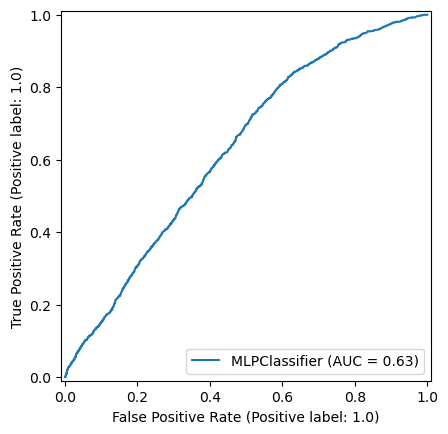

Accuracy of the binary classifier = 0.716 , ROC_AUC =  0.5459879379363519
Equalized Base Rate difference, closest final difference = 8.059526722875576e-05
[]
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  921.0/ 5081 = 18.099999999999998 %
Number of Callbacks in Test Set for Young People (After Treatment) 588.0/ 2699 = 21.8 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 27163 = 22.2 %
Number of Callbacks in Train Set for Old People (After Treatment) 3661.0/ 16472 = 22.2 %
Number of Callbacks in Train Set for Young People (After Treatment) 2377.0/ 10691 = 22.2 % 

Printing the list of 1509 forced predictions
[0.37865479 0.37835584 0.37835584 0.3782381  0.3782381  0.37809524
 0.378      0.37757143 0.37737551 0.37733333 0.3771515

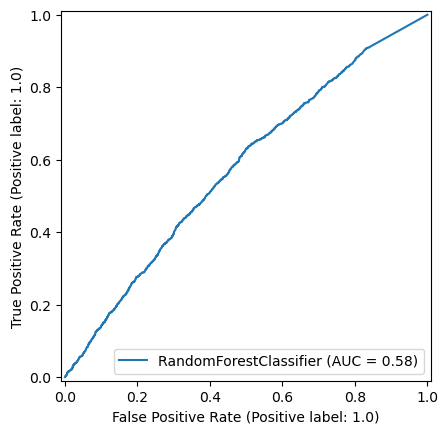

Accuracy of the binary classifier = 0.709 , ROC_AUC =  0.5350715036840034
Iteration 1, loss = 0.54594826
Validation score: 0.777696
Iteration 2, loss = 0.51290023
Validation score: 0.777696
Iteration 3, loss = 0.50775120
Validation score: 0.777696
Iteration 4, loss = 0.50472304
Validation score: 0.777696
Iteration 5, loss = 0.50166535
Validation score: 0.777696
Iteration 6, loss = 0.49941110
Validation score: 0.778064
Iteration 7, loss = 0.49656473
Validation score: 0.777696
Iteration 8, loss = 0.49440606
Validation score: 0.777328
Iteration 9, loss = 0.49197437
Validation score: 0.777696
Iteration 10, loss = 0.48920685
Validation score: 0.776592
Iteration 11, loss = 0.48677312
Validation score: 0.774015
Iteration 12, loss = 0.48355036
Validation score: 0.774752
Iteration 13, loss = 0.48143853
Validation score: 0.769599
Iteration 14, loss = 0.47927817
Validation score: 0.771071
Iteration 15, loss = 0.47584411
Validation score: 0.772175
Iteration 16, loss = 0.47431671
Validation score: 

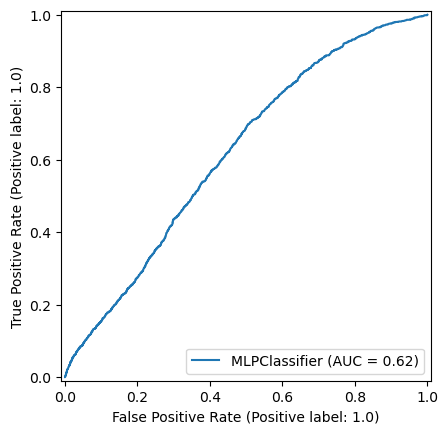

Accuracy of the binary classifier = 0.709 , ROC_AUC =  0.5350715036840034
Equalized Base Rate difference, closest final difference = 7.445035746922457e-05
[]
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  930.0/ 5190 = 17.9 %
Number of Callbacks in Test Set for Young People (After Treatment) 579.0/ 2590 = 22.400000000000002 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 27336 = 22.1 %
Number of Callbacks in Train Set for Old People (After Treatment) 3652.0/ 16536 = 22.1 %
Number of Callbacks in Train Set for Young People (After Treatment) 2386.0/ 10800 = 22.1 % 

Printing the list of 1509 forced predictions
[0.37333333 0.37332828 0.3732164  0.3732164  0.3732164  0.3732164
 0.3732164  0.3732164  0.37302742 0.37298413 0.37298413

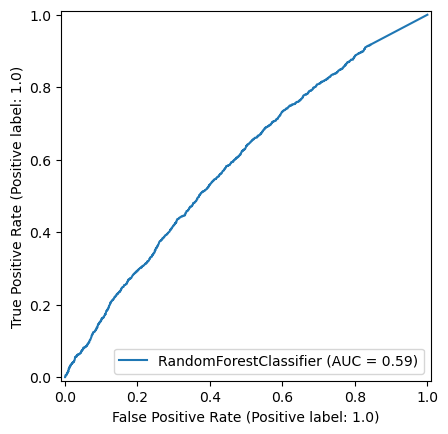

Accuracy of the binary classifier = 0.716 , ROC_AUC =  0.5465816698173792
Iteration 1, loss = 0.54441470
Validation score: 0.779078
Iteration 2, loss = 0.51305085
Validation score: 0.779078
Iteration 3, loss = 0.50827705
Validation score: 0.779078
Iteration 4, loss = 0.50541476
Validation score: 0.779078
Iteration 5, loss = 0.50191289
Validation score: 0.779078
Iteration 6, loss = 0.49984982
Validation score: 0.779078
Iteration 7, loss = 0.49827740
Validation score: 0.779078
Iteration 8, loss = 0.49584458
Validation score: 0.779078
Iteration 9, loss = 0.49294916
Validation score: 0.780541
Iteration 10, loss = 0.49075987
Validation score: 0.777249
Iteration 11, loss = 0.48861364
Validation score: 0.775786
Iteration 12, loss = 0.48627007
Validation score: 0.777981
Iteration 13, loss = 0.48482430
Validation score: 0.778713
Iteration 14, loss = 0.48191988
Validation score: 0.775055
Iteration 15, loss = 0.48027048
Validation score: 0.775421
Iteration 16, loss = 0.47720270
Validation score: 

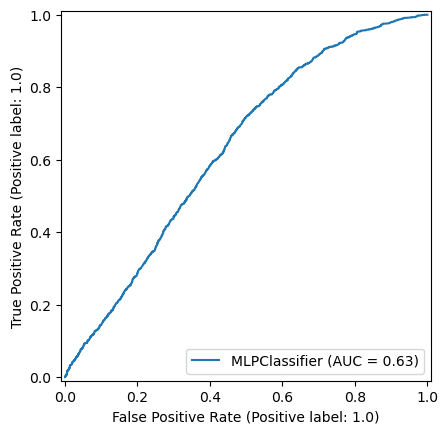

Accuracy of the binary classifier = 0.710 , ROC_AUC =  0.5363047357697223
Equalized Base Rate difference, closest final difference = 8.495124120608266e-05
[]
Probit Model for training data:
LinAlgError
['fold_1_train', 'fold_2_train', 'fold_3_train', 'fold_4_train', 'fold_5_train']
Test Set
Number of Callbacks in Test Set (After Treatment) 1509.0/ 7780 = 19.400000000000002 %
Number of Callbacks in Test Set for Old People (After Treatment)  922.0/ 5096 = 18.099999999999998 %
Number of Callbacks in Test Set for Young People (After Treatment) 587.0/ 2684 = 21.9 %

Train Set
Number of Callbacks in Train Set (After Treatment) 6038.0/ 27190 = 22.2 %
Number of Callbacks in Train Set for Old People (After Treatment) 3660.0/ 16484 = 22.2 %
Number of Callbacks in Train Set for Young People (After Treatment) 2378.0/ 10706 = 22.2 % 

Printing the list of 1509 forced predictions
[0.37357143 0.37333333 0.37310029 0.37310029 0.37303097 0.37283333
 0.37283333 0.37272294 0.37272294 0.37236508 0.3723650

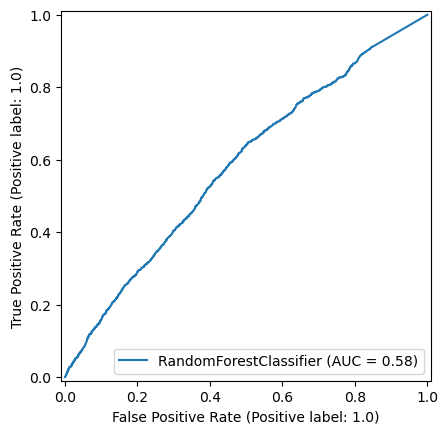

Accuracy of the binary classifier = 0.715 , ROC_AUC =  0.5437041282840351
Iteration 1, loss = 0.54695299
Validation score: 0.777860
Iteration 2, loss = 0.51502959
Validation score: 0.777860
Iteration 3, loss = 0.51020113
Validation score: 0.777860
Iteration 4, loss = 0.50694249
Validation score: 0.777860
Iteration 5, loss = 0.50429593
Validation score: 0.777860
Iteration 6, loss = 0.50103483
Validation score: 0.777860
Iteration 7, loss = 0.49985942
Validation score: 0.778963
Iteration 8, loss = 0.49681042
Validation score: 0.775653
Iteration 9, loss = 0.49414170
Validation score: 0.778227
Iteration 10, loss = 0.49085074
Validation score: 0.776388
Iteration 11, loss = 0.48923292
Validation score: 0.776388
Iteration 12, loss = 0.48727959
Validation score: 0.769033
Iteration 13, loss = 0.48387118
Validation score: 0.774182
Iteration 14, loss = 0.48119180
Validation score: 0.772343



KeyboardInterrupt



In [11]:
perc_wpm_young, perc_wpm_old = 0.6, 0.4
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_06 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_06 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_06 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_06 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_06 = {'base_rate': analytics_base_06,'equal_baserate': analytics_ebr_06, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_06, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_06}

with open('./Data/base_analytics_06.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


In [ ]:
perc_wpm_young, perc_wpm_old = 0.5, 0.5
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_05 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_05 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_05 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_05 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_05 = {'base_rate': analytics_base_05,'equal_baserate': analytics_ebr_05, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_05, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_05}

with open('./Data/base_analytics_05.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


In [ ]:
perc_wpm_young, perc_wpm_old = 0.339, 0.34435
#False means keep constant callbacks!!

perc_callback_old, perc_callback_young = False, False
df = pd.read_csv('./data/unemployment_with_state_cleaned.csv')

folder = f'./Data/bias_callback_data/'
skill_s= 'spanish'

file_name = f'inject_bias_{skill_s}_old_{perc_callback_old}_{perc_wpm_old}_young_{perc_callback_young}_{perc_wpm_young}_callback'
file_name = file_name.replace('.', '_')
data_string =folder+ file_name + '.txt'

df = inject_bias_skill_and_callback_relationship(df, perc_callback_old,perc_callback_young, perc_wpm_young, perc_wpm_old, skill= skill_s)
calculate_probabilities(df, file_name)

X =[]
states = [i for i in range(models_to_train)]
for m in range(models_to_train):
    df_x = process_data(df, folds = folds, random_state = states[m])
    X.append(df_x)
analytics_base_0339 = run_ML(X, age_coef= True,  stratify = stratify_Ar, resample_bool = False, models_to_train = models_to_train)
analytics_ebr_0339 = run_ML(X,eq_base_rate= True, age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
equal_baserate_train_ITE_test_0339 = run_ML(X,eq_base_rate= True, test= 'ITE', age_coef = True, stratify = stratify_Ar, models_to_train = models_to_train)
analytics_ITE_test_flip_0339 = run_ML(X, age_coef= True,  stratify = stratify_Ar,  flip_ITE_bool = True, test = True, flip_test = True, models_to_train = models_to_train)

analytics_dict_base_0339 = {'base_rate': analytics_base_0339,'equal_baserate': analytics_ebr_0339, 'flipped_ITE_test_and_train' : analytics_ITE_test_flip_0339, 'equal_baserate_train_ITE_test': equal_baserate_train_ITE_test_0339}

with open('./Data/base_analytics_0339.txt', "w") as outfile: 
    json.dump(analytics_dict_base, outfile, cls=NpEncoder)


## Fairness Comparison: Selection Bias Due to Spanish Skill by Age Group
This section reproduces **Figure 3** on page 7, illustrating the fairness comparison in the presence of **selection bias** caused by varying Spanish language skills across age groups.

We define **Disparity** as:

$$
\text{Disparity} = P(\text{Spanish} = 1 \mid A = y) - P(\text{Spanish} = 1 \mid A = o)
$$

Where:
- $A = y$: Younger group  
- $A = o$: Older/ Middle group  
- $P(\text{Spanish} = 1 \mid A)$: Probability that an applicant speaks Spanish given their age group



(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)


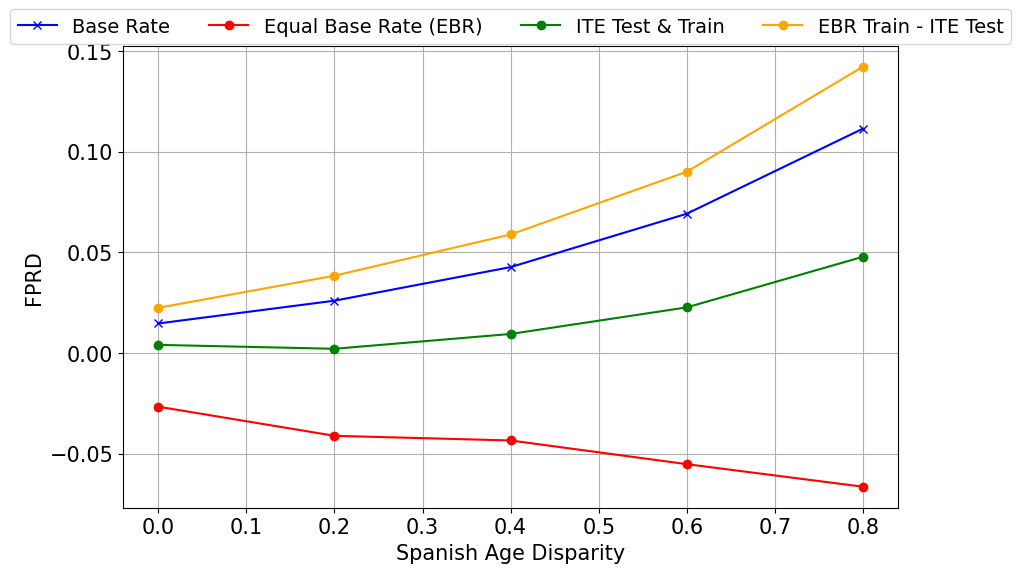

(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)
(0.0, 0.19999999999999996, 0.39999999999999997, 0.6000000000000001, 0.8)


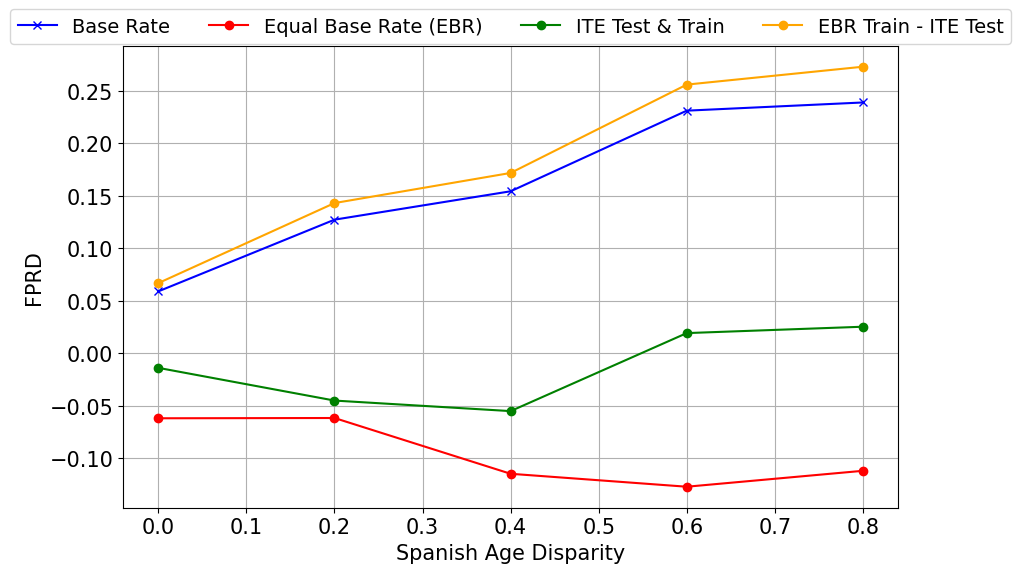

In [24]:
directory = './data/bias_callback_data/'
measurement_names = {'FP_dif': 'FPRD', 'FPR_o': "FPR Old", 'FPR_y': 'FPR Young', 'FPR': 'FPR'}

plot_mean_measurement(directory, 'FP_dif', model= 'RFR')

plot_mean_measurement(directory, 'FP_dif', model='MLP')